# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1:</center>
### <center>  Propiedades en Venta</center>
### <center>  Grupo 18</center>


#### **Integrantes:**

* Analía Acevedo
* Santiago Daniel Marczewski Neudeck
* Lucia Belén Napoli
* Brayan Ricaldi

#### **Introducción**

En este trabajo práctico se propone que cada grupo de alumnos se enfrente a un problema real
de ciencia de datos, que trabaje en cada una de las etapas del proceso y que pueda resolverlo
aplicando los contenidos que vemos en la materia.

Vamos a utilizar el conjunto de datos provisto por la empresa [Properati](https://www.properati.com.ar/) correspondiente a anuncios de propiedades en venta de la República Argentina publicados durante el año 2021 .
La información fue extraída desde BigQuery (producto de Google Cloud para consultar grandes
volúmenes de datos) donde la empresa disponibiliza sus datasets con avisos de propiedades y
desarrollos inmobiliarios que están y estuvieron publicados en Properati en todo Latinoamérica
desde 2015 hasta dos meses atrás. Los datos se actualizan diariamente para mayor información
pueden consultar el siguiente [link](https://www.properati.com.ar/data/).

El objetivo principal del trabajo será aplicar técnicas de análisis exploratorio, preprocesamiento
de datos, agrupamiento, clasificación y regresión. En la sección enunciado se detallan los
objetivos particulares.

#### **Descargamos en DataSet**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sklearn.preprocessing as skp
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from preprocessing import preprocesamiento

pd.options.display.max_columns = None

In [2]:
url='https://drive.google.com/file/d/1wScqb_M8lq3yL3ZfSZvnLyZbh4ImI7dI/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
dp_properati = pd.read_csv(url)

# dp_properati = pd.read_csv("./Datasets/properati_argentina_2021.csv")

In [3]:
df = dp_properati.copy()

Damos un primer vistazo al dataset

In [4]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


In [5]:
df.shape

(460154, 20)

Podemos ver que tenemos al rededor de 460 mil entradas y 20 columnas:
* id: Un codigo de identificacion.
* start_date: La fecha de inicio de la publicacion.
* end_date: La fecha de finalizacion de la publicacion.
* created_on: La fecha de creacion de la publicacion.
* latitud: La latitud en la que se encuentra la propiedad.
* longitud: La longitud en la que se encuentra la propiedad.
* place_2..n: Son 5 columnas con datos sobre la ubicacion de la propiedad, como provincia, ciudad, barrio, etc.
* operation: El tipo de operacion de la publicacion, como venta, alquiler, etc.
* property_type: El tipo de propiedad, como casa, departamento, PH, etc.
* property_room: La cantidad de ambientes que posee la propiedad.
* property_bedroom: La cantidad de dormitorios que posee la propiedad.
* property_surface_total: La superficie total de la propiedad.
* property_surface_covered: La superficie cubierta de la propiedad.
* property_price: El precio de la propiedad.
* property_currency: La moneda en la que esta expresada el precio publicado.
* property_title: El titulo de la publicacion.

#### **Enunciado**
El conjunto de datos a utilizar properati_argentina_2021 se encuentra disponible en el
siguiente [enlace](https://drive.google.com/drive/folders/1BPCdW_Jab91WhMqfXcf0jYMHzjxW_XkD?usp=sharing), la descripción de las variables se encuentra disponible [aquí](https://www.properati.com.ar/data/). Para este trabajo
se plantean los siguientes objetivos generales:

* _Agrupamiento_: el objetivo será analizar si es posible agrupar los datos en función de
algún criterio, identificando a qué obedece el mismo.

* _Clasificación_: el objetivo será clasificar cada anuncio en tres categorías relacionadas al
precio de venta (alto, medio y bajo).

* _Regresión_: el objetivo será predecir el precio de venta en dólares de una propiedad tipo
vivienda ubicada en Capital Federal.

A continuación se detallan las etapas que deben ser desarrolladas en el trabajo:

### **1. Análisis Exploratorio y Preprocesamiento de Datos**
El primer paso consiste en la selección de los datos que se van a utilizar, se deben filtrar
únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados
en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).
Se debe separar un conjunto de entrenamiento (80%) y un conjunto de test (20%).

<h4 align="center"><b> Filtro por el enunciado </b></h4>

In [6]:
# Vamos a eliminar las filas que tengan precio en pesos o NaN
idx_prices = df[df.property_currency.apply(lambda curr: curr != "USD")].index
df.drop(idx_prices, inplace=True)
# Tambien eliminamos las propiedades que no se encuentren en Capital Federal
idx_location = df[df.place_l2.apply(lambda loc: loc != "Capital Federal")].index
df.drop(idx_location, inplace=True)
# Eliminamos las que no sean operaciones de tipo venta
idx_op = df[df.operation.apply(lambda op: op != "Venta")].index
df.drop(idx_op, inplace=True)
# Por ultimo eliminamos las que no sean de tipo vivienda
type_vivienda = ["Departamento", "PH", "Casa"]
idx_type = df[df.property_type.apply(lambda t: t not in type_vivienda)].index
df.drop(idx_type, inplace=True)
# Y reseteamos indices
df.reset_index(drop=True, inplace=True)

df.shape

(94249, 20)

Vemos si hay datos raros en el dataset properati

In [7]:
con_caracter_raro = df.astype("str").eq("-").any(0)
con_caracter_raro

id                          False
start_date                  False
end_date                    False
created_on                  False
latitud                     False
longitud                    False
place_l2                    False
place_l3                    False
place_l4                    False
place_l5                    False
place_l6                    False
operation                   False
property_type               False
property_rooms              False
property_bedrooms           False
property_surface_total      False
property_surface_covered    False
property_price              False
property_currency           False
property_title              False
dtype: bool

Vemos si hay filas duplicadas

In [8]:
# Armamos lista de las columnas excluyendo las que podrian dar problemas a la hora de identificar duplicados
columns = df.columns.tolist()[4:]
# Y buscamos duplicados
df[df.duplicated(subset=columns[:-1])].head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
49,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,NaN,NaN,Venta,Departamento,NaN,4.0,400.0,NaN,2700000.0,USD,Departamento - Palermo Chico
186,5fV18BNo0KALCwNBrnNwlw==,2021-09-09,2022-01-27,2021-09-09,-34.604660,-58.395385,Capital Federal,Barrio Norte,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,42.0,38.0,85000.0,USD,Ayacucho 400 Monoambiente A ESTRENAR!
187,LIeYF5ewYWkjtBZb8xKt3g==,2021-09-09,2022-01-27,2021-09-09,-34.604660,-58.395385,Capital Federal,Barrio Norte,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,42.0,38.0,85000.0,USD,Ayacucho 400 Monoambiente A ESTRENAR!
188,ZB4UnAasDWbvahAXoG6m3A==,2021-09-09,2022-01-27,2021-09-09,-34.604660,-58.395385,Capital Federal,Barrio Norte,NaN,NaN,NaN,Venta,Departamento,1.0,1.0,42.0,38.0,85000.0,USD,Ayacucho 400 Monoambiente A ESTRENAR!
243,53k8bQTyzBZ5vCcAjKIo6g==,2021-09-09,2022-02-09,2021-09-09,-34.580818,-58.491051,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,1.0,100.0,87.0,189645.0,USD,POZO 3 AMBIENTES COCHERA OPCIONAL - VILLA URQUIZA


Las borramos y vemos cuantas son:

In [9]:
size_antes = len(df)
# Finalmente borramos los duplicados
df = df.drop_duplicates(subset=columns[:-1])
# Y reseteamos indices
df.reset_index(drop=True, inplace=True)
size_despues = len(df)
print(f"Se eliminaron: {size_antes-size_despues} filas duplicadas")

Se eliminaron: 13236 filas duplicadas


Vemos la suma de datos nulos por columna

In [10]:
print(df.isna().sum())

id                              0
start_date                      0
end_date                        0
created_on                      0
latitud                      3136
longitud                     3136
place_l2                        0
place_l3                      395
place_l4                    78114
place_l5                    81013
place_l6                    81013
operation                       0
property_type                   0
property_rooms                958
property_bedrooms            9596
property_surface_total       4206
property_surface_covered     2828
property_price                  0
property_currency               0
property_title                  0
dtype: int64


Y tambien que porcentaje representan del total

In [11]:
filas_totales = df.shape[0]
print(df.isna().sum() / filas_totales * 100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.870984
longitud                      3.870984
place_l2                      0.000000
place_l3                      0.487576
place_l4                     96.421562
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.182526
property_bedrooms            11.845013
property_surface_total        5.191759
property_surface_covered      3.490798
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


Se observa que hay un gran porcentaje de datos nulos en el feature place_l4. Ademas podemos ver que las features place_l5 y place_l6 tienen el 100% de sus filas nulas.

Solo nos quedamos con las longitudes y latitudes que pertenezca aproximadamente a Capital Federal

In [12]:
# Guardamos el tamano del dataset
size_antes = len(df)
# Primero nos quedamos solamente con las filas con longitudes validas
df = df[((-58.5314375 < df["longitud"]) & (df["longitud"] < -58.3415625)) | (df["longitud"].isna())]
# Y luego repetimos el proceso para las latitudes
df = df[((-34.7045625 < df["latitud"]) & (df["latitud"] < -34.5270625)) | (df["latitud"].isna())]
# Buscamos el tamano del dataset despues de sacar coordenadas invalidas
size_despues = len(df)
# Y reseteamos indices
df.reset_index(drop=True, inplace=True)
print(f"Se eliminaron: {size_antes-size_despues} filas con coordenadas invalidas, lo cual representa un {round((size_antes-size_despues) / size_antes * 100, 3)}%")

Se eliminaron: 190 filas con coordenadas invalidas, lo cual representa un 0.235%


In [13]:
tam_inicial=df.shape[0]
print(f"El tamano inicial del dataset luego de tomar solamente los datos requeridos es de: {tam_inicial} filas")

El tamano inicial del dataset luego de tomar solamente los datos requeridos es de: 80823 filas


**a) Exploración Inicial:** analizar cada variable, considerando los siguientes aspectos
* Tipo de variable
* Variables Cuantitativas: calcular medidas de resumen: media, mediana, q1,
q3, moda.
* Variables Cualitativas mostrar cantidad de valores posibles, y frecuencias de cada
uno.
* Determinar variables irrelevantes en el análisis (Ids por ejemplo)
* Realizar un análisis gráfico de las distribuciones de las variables
* Analizar las correlaciones existentes entre las variables.

A partir de este análisis generar conclusiones sobre los datos.



<h4 align="center"><b> Tipo de variable </b></h4>

In [14]:
df.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80823 entries, 0 to 80822
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        80823 non-null  object 
 1   start_date                80823 non-null  object 
 2   end_date                  80823 non-null  object 
 3   created_on                80823 non-null  object 
 4   latitud                   77687 non-null  float64
 5   longitud                  77687 non-null  float64
 6   place_l2                  80823 non-null  object 
 7   place_l3                  80618 non-null  object 
 8   place_l4                  2899 non-null   object 
 9   place_l5                  0 non-null      object 
 10  place_l6                  0 non-null      float64
 11  operation                 80823 non-null  object 
 12  property_type             80823 non-null  object 
 13  property_rooms            79917 non-null  float64
 14  proper

Se observa que hay 12 variables string, 8 float

<h4 align="center"><b> Variables Cuantitativas - calcular medidas de resumen: media, mediana, q1
q3, moda. </b></h4>

<h4 align="center"><b> Realizar un análisis gráfico de las distribuciones de las variables </b></h4>

Veamos un resumen general estadistico de las variables cuantitativas:

In [15]:
medidas_resumen=df.describe()
medidas_resumen

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
count,77687.000000,77687.000000,0.0,79917.000000,71239.00000,76639.000000,77995.000000,8.082300e+04
mean,-34.596741,-58.439070,NaN,2.814670,2.01116,105.976318,87.909802,2.143545e+05
std,0.026524,0.038171,NaN,1.414939,1.13695,990.250355,1069.151461,2.855791e+05
min,-34.698989,-58.530391,NaN,1.000000,-1.00000,10.000000,1.000000,5.000000e+03
25%,-34.616636,-58.466707,NaN,2.000000,1.00000,45.000000,40.000000,9.500000e+04
50%,-34.596323,-58.439267,NaN,3.000000,2.00000,65.000000,57.000000,1.400000e+05
75%,-34.577847,-58.409025,NaN,4.000000,3.00000,102.000000,87.000000,2.300000e+05
max,-34.535964,-58.343239,NaN,40.000000,70.00000,137000.000000,217000.000000,2.140000e+07


#### Observemos cada feature en mas detalle:

In [16]:
"""
Precondicion: 
        - f debe ser un feature numerico de df y contener al menos una fila valida.
"""

def imprimir_resumen(df, f):
    media = round(df[f].mean(),1)
    mediana = df[f].median()
    cuantiles = df[f].quantile(q=[0.25,0.75])
    moda = df[f].mode()
    q1=round(cuantiles.iloc[0],1)
    q3=round(cuantiles.iloc[1],1)
    return pd.DataFrame({'media': media,'mediana': mediana,'q1': q1,'q3': q3,'moda': moda[0]}, index=[f])

#### Fecha de publicacion (dia y mes):

#### Vamos a parsear la fecha de creacion de la publicacion, creando dos nuevas features antes de borrar la original:

In [17]:
"""
Precondicion: 
        - f debe ser un feature de df.
        - Los datos de f son del formato yy-mm-dd
        - yy/mm/dd son int en formato string
"""


def procesar_fechas(df, f):
    day = []
    month = []
    year = []
    for date in df[f]:
        _year, _month, _day = date.split("-")
        day.append(int(_day))
        month.append(int(_month))
        year.append(int(_year))
    return day, month, year

In [18]:
# Descartamos el anio porque al ser un dataset unicamente del anio 2021 es un valor redundante
created_on_day, created_on_month, created_on_year = procesar_fechas(df, "created_on")
df["dia"] = created_on_day
df["mes"] = created_on_month

Text(0.5, 1.0, 'Distribucion de mes de publicacion')

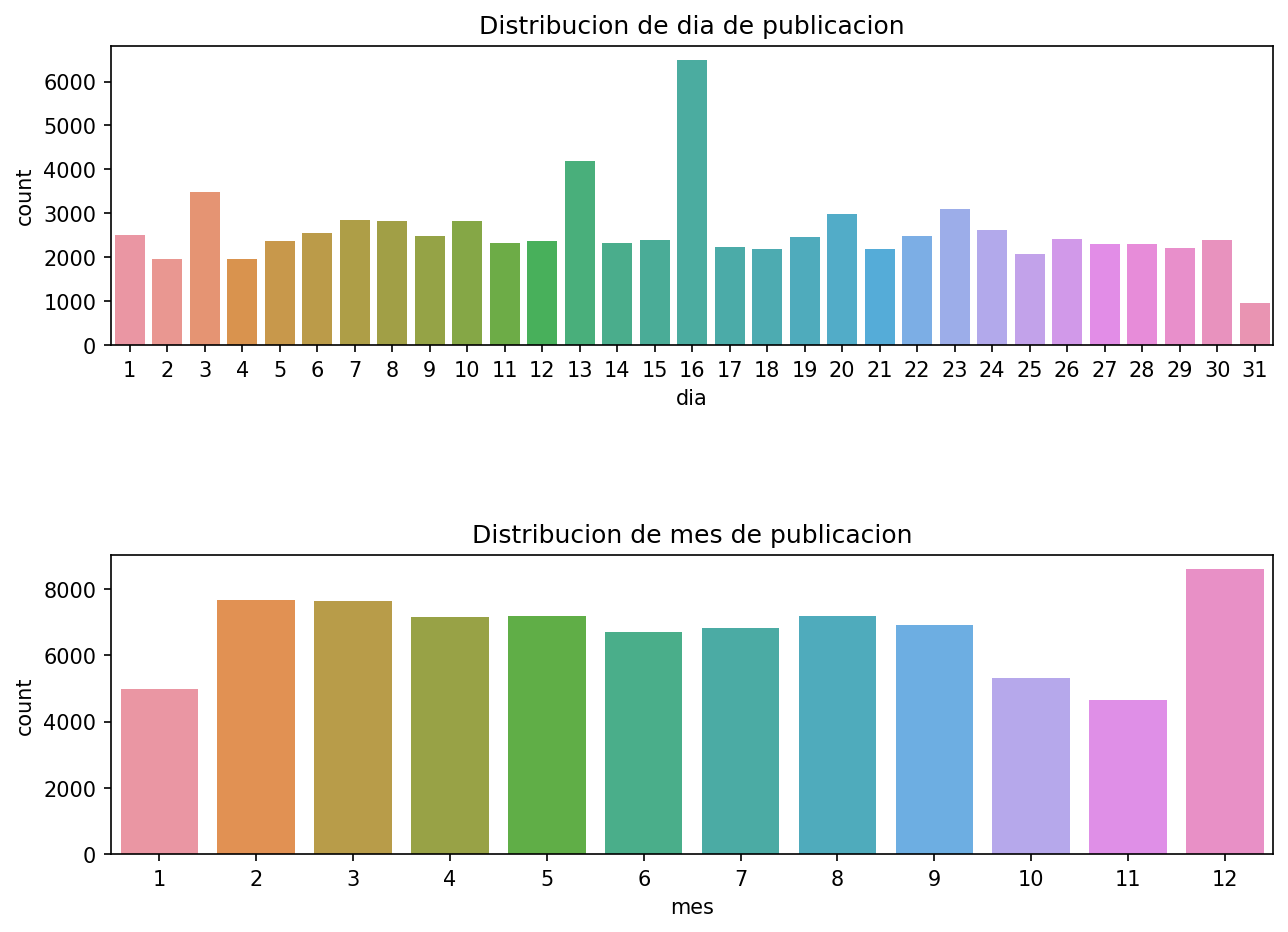

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=150, figsize=(10, 7))
sns.countplot(
    x="dia",
    data=df,
    ax=axes[0],
)
sns.countplot(
    x="mes",
    data=df,
    ax=axes[1],
)
plt.subplots_adjust(hspace=0.7)
axes[0].set_title("Distribucion de dia de publicacion")
axes[1].set_title("Distribucion de mes de publicacion")

Podemos observar que el mes mas popular para publicar una propiedad a la venta es Diciembre, mientras que el dia mas elegido es el 16.

#### Longitud y Latitud:

In [20]:
# Medidas de resumen para la variable longitud
imprimir_resumen(df, 'longitud')

,media,mediana,q1,q3,moda
longitud,-58.4,-58.439267,-58.5,-58.4,-58.424956


In [21]:
# Medidas de resumen para la variable latitud
imprimir_resumen(df, 'latitud')

,media,mediana,q1,q3,moda
latitud,-34.6,-34.596323,-34.6,-34.6,-34.604538


Text(0.5, 1.0, 'Latitud')

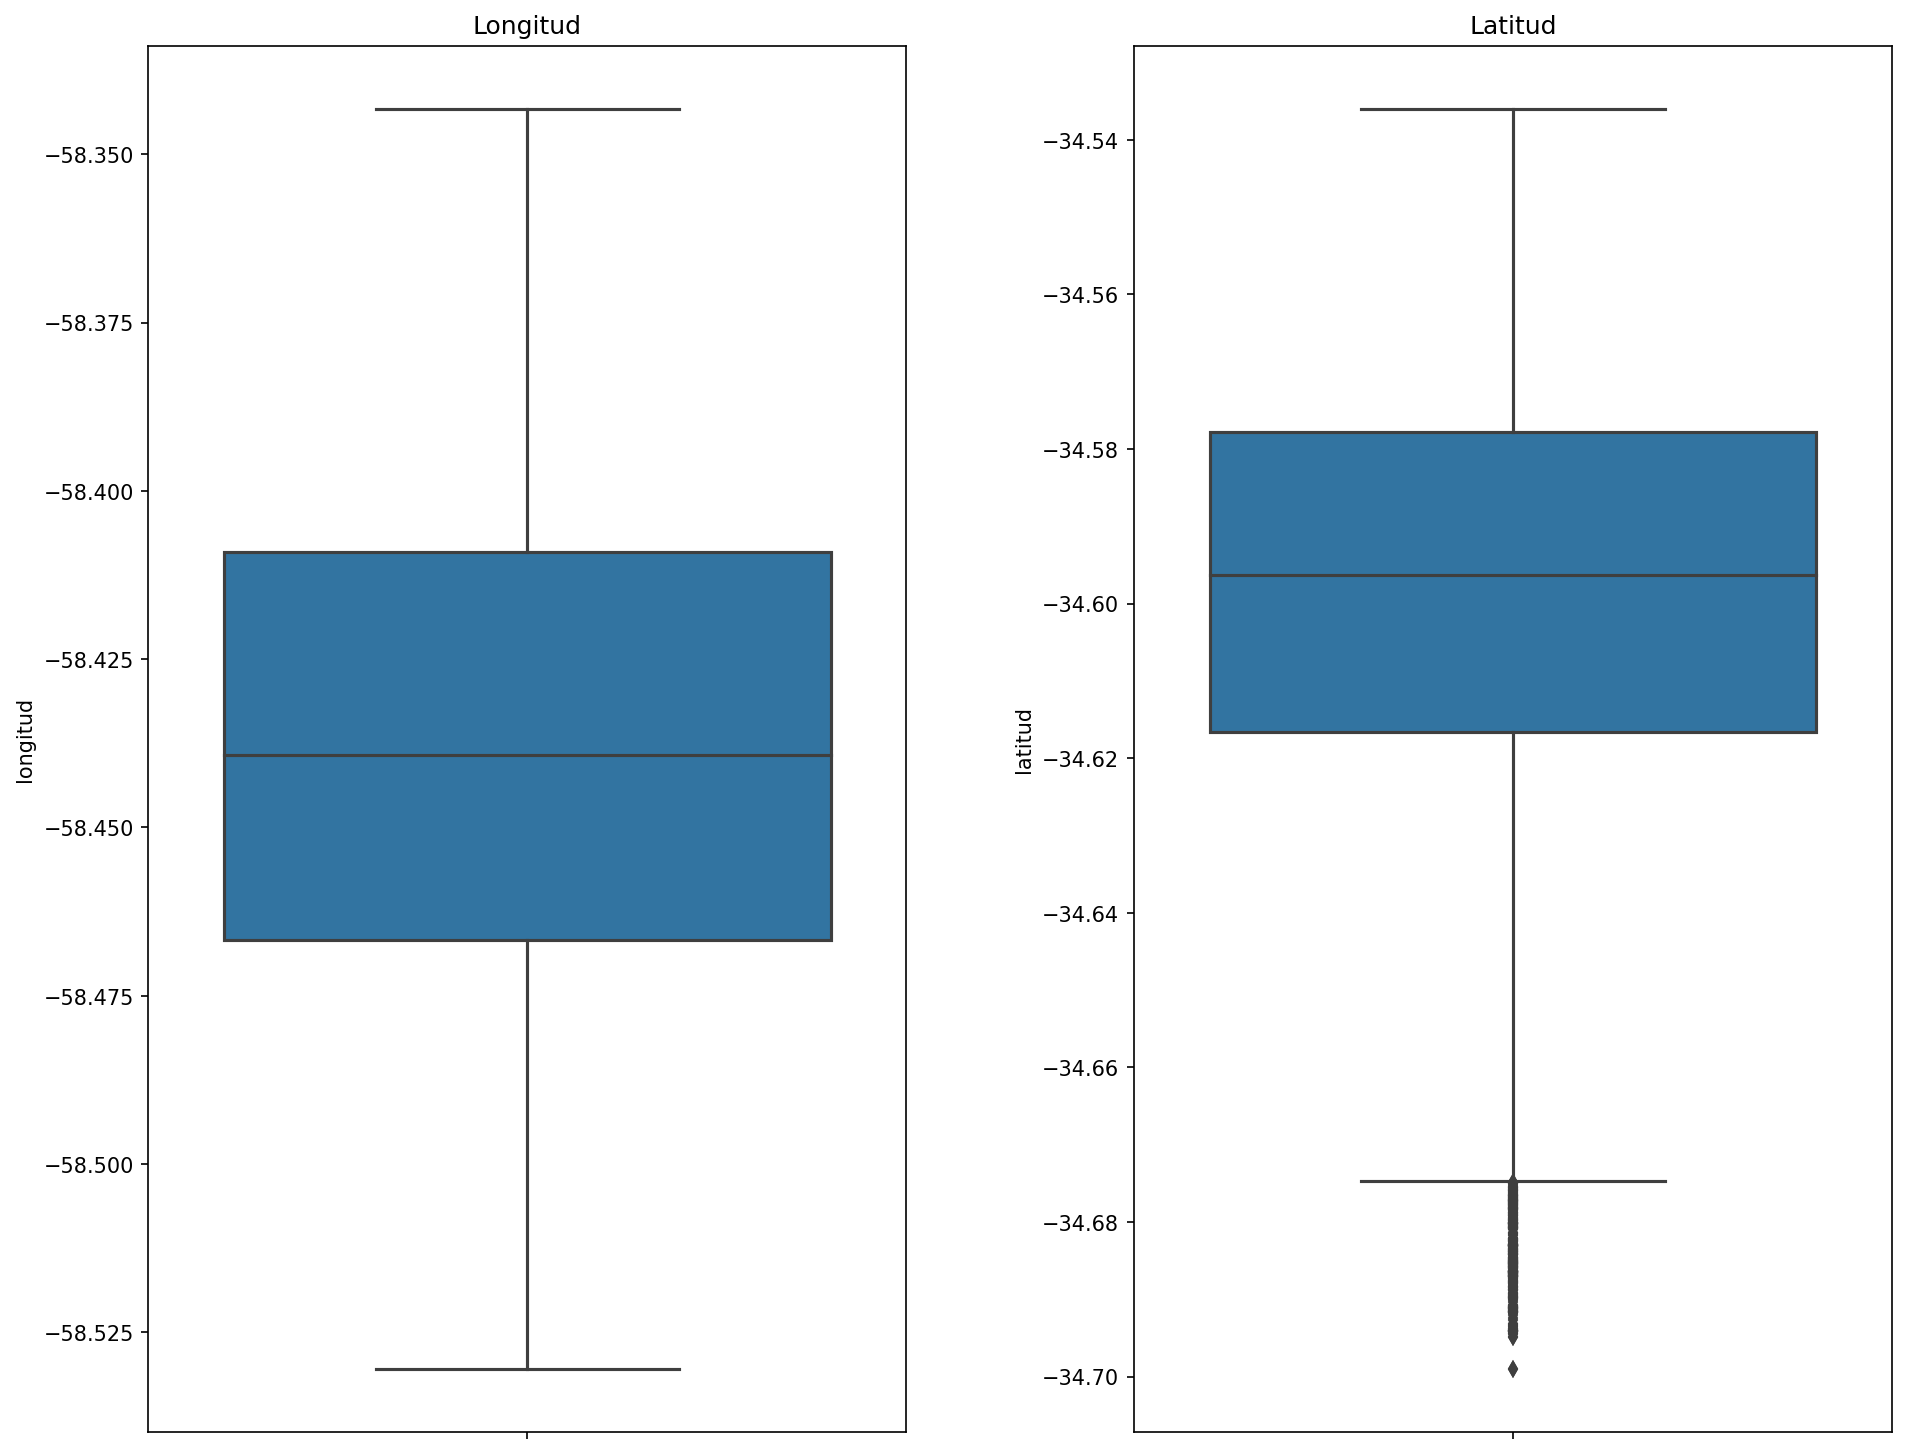

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(15, 12))
sns.boxplot(y=df["longitud"], ax=axes[0])
sns.boxplot(y=df["latitud"], ax=axes[1])
plt.subplots_adjust(wspace=0.3)
axes[0].set_title("Longitud")
axes[1].set_title("Latitud")

#### Precio (property_price):

In [23]:
# Medidas de resumen para la variable property_price
imprimir_resumen(df, 'property_price')

,media,mediana,q1,q3,moda
property_price,214354.5,140000.0,95000.0,230000.0,110000.0


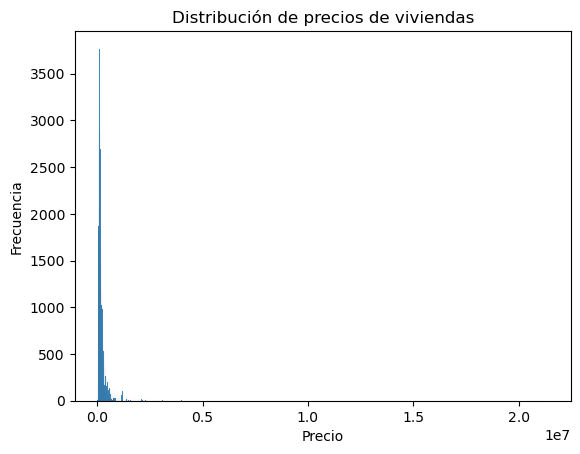

In [24]:
# Histograma de los precios
# sns.set(rc={"figure.figsize":(10, 45)})
sns_hist = sns.histplot(data=df["property_price"], alpha=0.85).set(
    title="Distribución de precios de viviendas", xlabel="Precio", ylabel="Frecuencia"
)

#### Ambientes (property_rooms):

In [25]:
# Medidas de resumen para la variable property_rooms
imprimir_resumen(df, 'property_rooms')

,media,mediana,q1,q3,moda
property_rooms,2.8,3.0,2.0,4.0,3.0


In [26]:
# Vemos cuantos valores unicos hay en la columna, el dato es interesante ya que el rango de valores deberia ser bastante acotado
print(f"El feature Ambientes tiene: {len(df.property_rooms.unique())} valores unicos")

El feature Ambientes tiene: 28 valores unicos


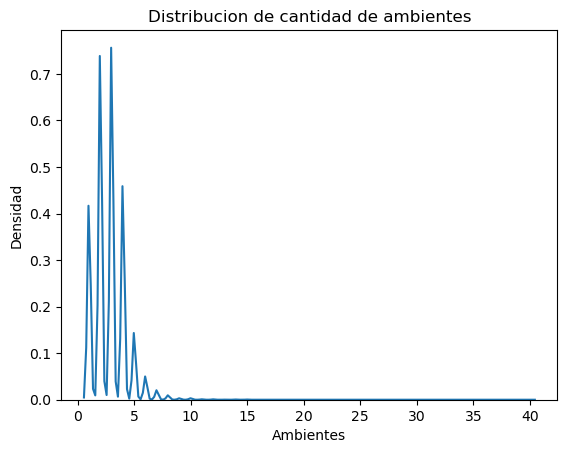

In [27]:
# Distribucion de la variable property_rooms
sns_hist = sns.kdeplot(data=df.property_rooms).set(
    title="Distribucion de cantidad de ambientes", xlabel="Ambientes", ylabel="Densidad"
)

#### Dormitorios (property_bedrooms)

In [28]:
# Medidas de resumen para la variable property_bedrooms
imprimir_resumen(df, 'property_bedrooms')

,media,mediana,q1,q3,moda
property_bedrooms,2.0,2.0,1.0,3.0,1.0


In [29]:
# Vemos cuantos valores unicos hay en la columna, el dato es interesante ya que el rango de valores deberia ser bastante acotado
print(f"El feature Dormitorios tiene: {len(df.property_bedrooms.unique())} valores unicos")

El feature Dormitorios tiene: 25 valores unicos


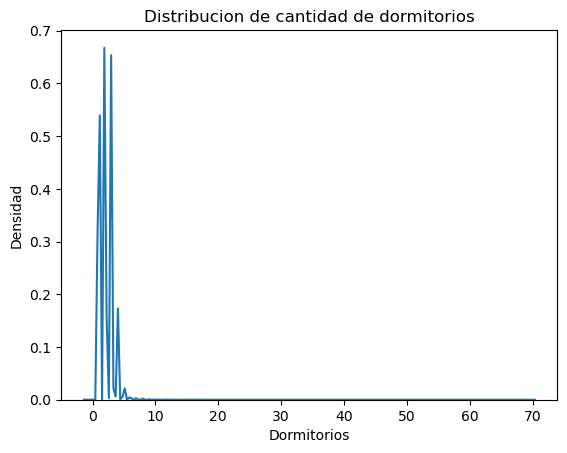

In [30]:
# Distribucion de la variable property_bedrooms
sns_hist = sns.kdeplot(data=df.property_bedrooms).set(
    title="Distribucion de cantidad de dormitorios",
    xlabel="Dormitorios",
    ylabel="Densidad",
)

#### Superficie total (property_surface_total)

In [31]:
# Medidas de resumen para la variable property_surface_total
imprimir_resumen(df, 'property_surface_total')

,media,mediana,q1,q3,moda
property_surface_total,106.0,65.0,45.0,102.0,50.0


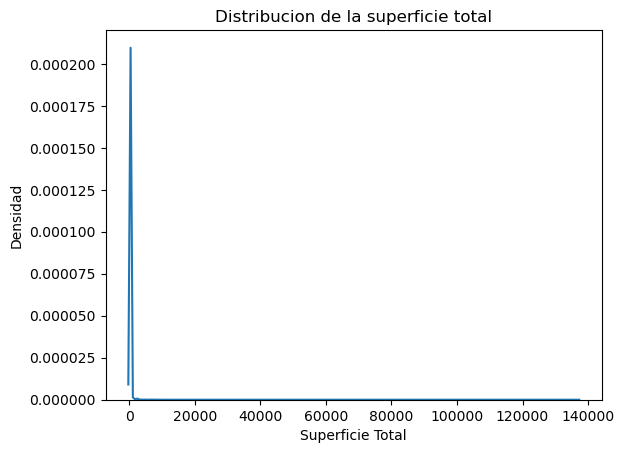

In [32]:
# Distribucion de la variable property_surface_total
sns_hist = sns.kdeplot(data=df.property_surface_total).set(
    title="Distribucion de la superficie total",
    xlabel="Superficie Total",
    ylabel="Densidad",
)

#### Superficie cubierta (property_surface_covered)

In [33]:
# Medidas de resumen para la variable property_surface_covered
imprimir_resumen(df, 'property_surface_covered')

,media,mediana,q1,q3,moda
property_surface_covered,87.9,57.0,40.0,87.0,40.0


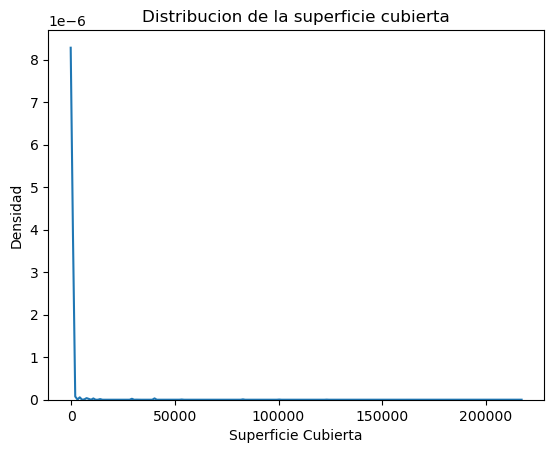

In [34]:
# Distribucion de la variable property_surface_covered
sns_hist = sns.kdeplot(data=df.property_surface_covered).set(
    title="Distribucion de la superficie cubierta",
    xlabel="Superficie Cubierta",
    ylabel="Densidad",
)

<h4 align="center"><b> Variables Cualitativas - mostrar cantidad de valores posibles, y frecuencias de cada
uno </b></h4>

#### Tipo (property_type)

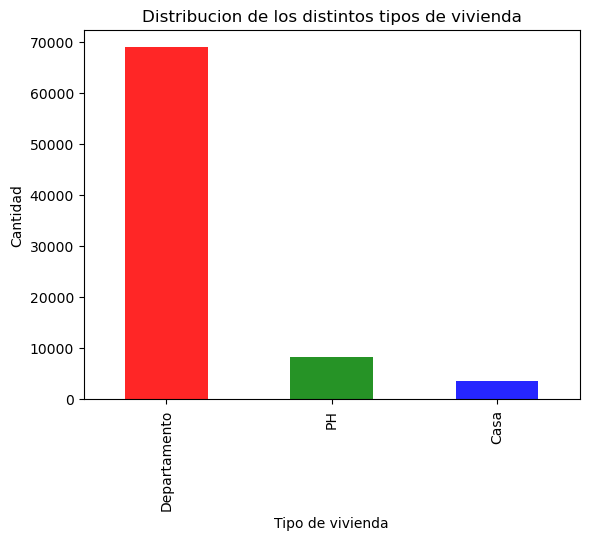

In [35]:
# Gráfico de barras
grf_ds = (
    df["property_type"]
    .value_counts()
    .plot.bar(
        alpha=0.85,
        title="Distribucion de los distintos tipos de vivienda",
        xlabel="Tipo de vivienda",
        ylabel="Cantidad",
        color=['r','g','b']
    )
)

Podemos ver que el tipo mas frecuente de propiedad es Departamento.

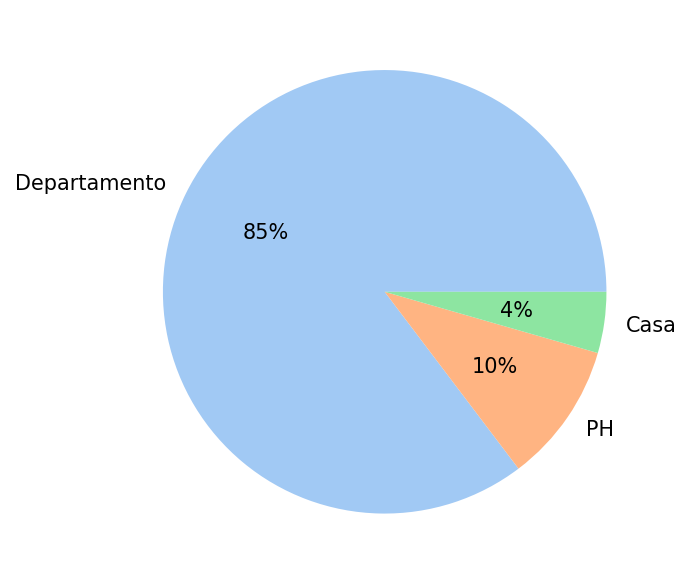

In [36]:
# Grafico de torta
plt.figure(dpi=150)
data = df["property_type"].value_counts()
labels = df["property_type"].value_counts().index
colors = sns.color_palette("pastel")

plt.pie(data, labels=labels, colors=colors, autopct="%.0f%%")
plt.show()

Especificamente el 86% de los datos corresponde a una publicacion de departamento.

#### Barrios (place_l3)

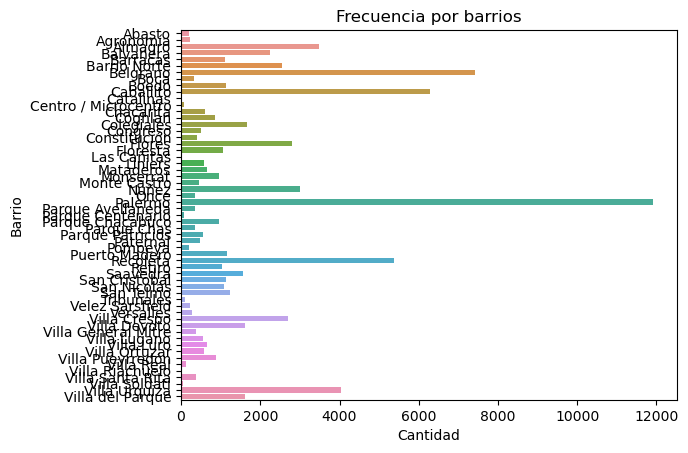

In [37]:
# Seaborn
ds_agrupado_Pclass = df.groupby(
    ["place_l3"]
).count()  # Calculo la frecuencia de cada barrio

eje_y = ds_agrupado_Pclass.index.tolist()
eje_x = ds_agrupado_Pclass["property_price"].tolist()
# sns.set(rc={"figure.figsize":(15, 45)})
sns_bar_plot = sns.barplot(
    x=eje_x, y=eje_y, data=ds_agrupado_Pclass, orient="h"
).set(title="Frecuencia por barrios", xlabel="Cantidad", ylabel="Barrio")

#### Título del anuncio (property_title)

Si bien la informacion que podamos obtener del titulo de la publicacion es limitada al ser un campo que puede cambiar mucho y depende exclusivamente de la persona que la escribe, vamos a analizarla de todas maneras para intentar encontrar algo que pueda servirnos.

In [38]:
df["property_title"].value_counts().head(60)

Departamento - Palermo                             1155
Departamento - Recoleta                            1142
Departamento - Belgrano                             995
Departamento - Caballito                            822
Departamento - Almagro                              551
Departamento - Barrio Norte                         550
Departamento - Villa Urquiza                        548
Departamento - Villa Crespo                         428
Departamento - Flores                               402
Departamento - Nuñez                                397
Departamento venta                                  334
Departamento - Balvanera                            321
Departamento - Puerto Madero                        299
Departamento - Palermo Hollywood                    296
Departamento - San Telmo                            274
Departamento - Las Cañitas                          259
Departamento - Colegiales                           243
Departamento - Saavedra                         

Entre los formatos mas populares se encuentra: TIPO - BARRIO.

In [39]:
df["property_title"].value_counts().tail(10)

Nuevo Ingreso Chateau Puerto Madero                                                                     1
Venta dpto 4 amb con baulera en San Cristobal                                                           1
Departamento · 3 Ambientes c/ Cochera· Pasco 1000 · San Cristobal                                       1
Venta Dto 3 amb c/patio Excelente Estado V Urquiza                                                      1
Oportunidad monoambiente  a metros del subte B                                                          1
MUY BUEN SEMIPISO AL CONTRAFRENTE CON BALCÓN, VISTA ABIERTA.-                                           1
Venta Departamento 3 ambientes con dependencia, balcón y lavadero Villa Urquiza                         1
Hermoso y luminoso 3 ambientes con balcón en el barrio de Villa Urquiza!                                1
Duplex 3 Ambientes - Jardines De Roosevelt - V. Urquiza                                                 1
VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF 

Y naturalmente entre los formatos menos frecuentes encontramos convenciones muy variadas.

In [40]:
df_title = df.groupby("property_title").filter(lambda x: len(x) > 200)

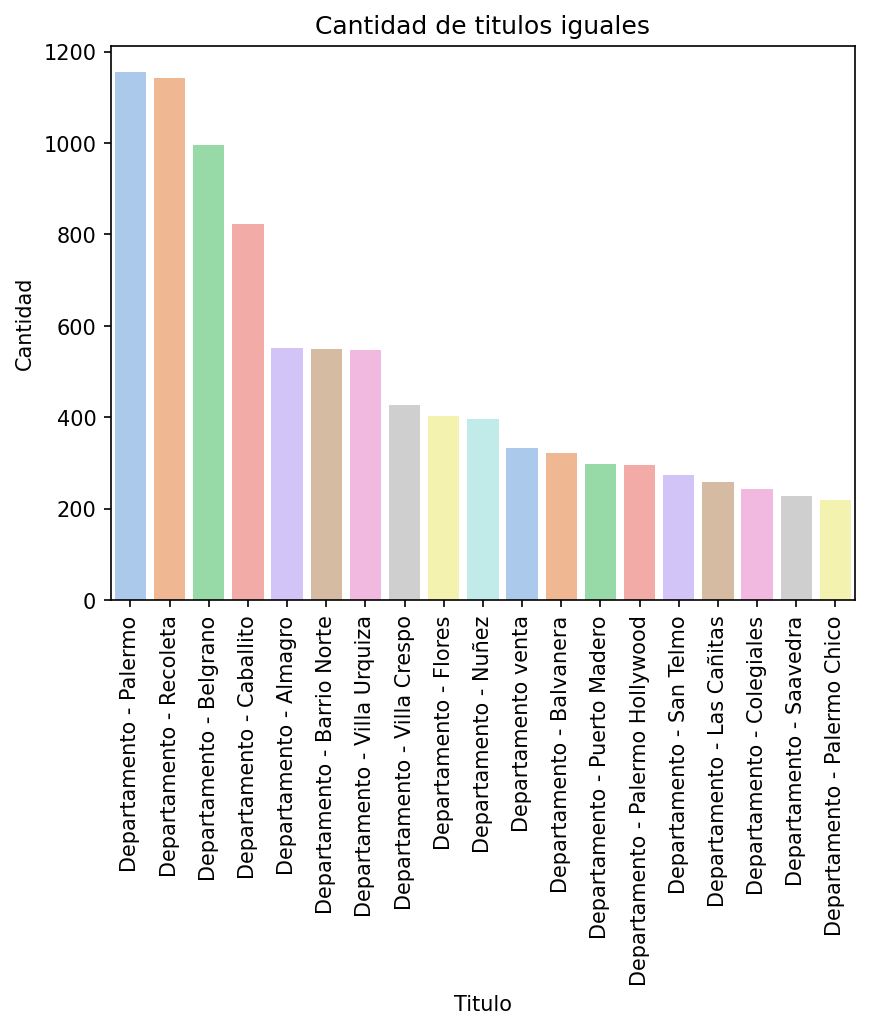

In [41]:
plt.figure(dpi=150)
colors = sns.color_palette("pastel")
sns.countplot(
    x="property_title",
    data=df_title,
    palette=colors,
    order=df_title.property_title.value_counts().index,
)
plt.ylabel("Cantidad")
plt.xlabel("Titulo")
plt.xticks(rotation=90)
plt.title("Cantidad de titulos iguales")
plt.show()

In [42]:
df_t = df["property_title"].str.split("-", expand=True)
df_t.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,VENTA CASA LLAVE EN MANO,COSTA ESMERALDA,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,VENTA TRES AMBIENTES LA BOCA PISO ALTO,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,Departamento,4 Ambientes,Catalinas Sur,None,None,None,None,None,None,None,None,None,None,None,None,None
3,Venta departamento 4 ambientes Once,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,PH,Boedo,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [43]:
df_t = df_t[[0, 1]]
df_t.columns = ["Tipo", "Barrio"]
df_t

,Tipo,Barrio
0,VENTA CASA LLAVE EN MANO,COSTA ESMERALDA
1,VENTA TRES AMBIENTES LA BOCA PISO ALTO,None
2,Departamento,4 Ambientes
3,Venta departamento 4 ambientes Once,None
4,PH,Boedo
...,...,...
80818,Espectacular 4 amb130m2 con Balcon Terraza!!!,None
80819,3 ambientes con cochera listo para habitar!,None
80820,VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...,None
80821,VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...,None


In [44]:
df_t = df_t.loc[
    (df_t["Tipo"] == "Casa") | (df_t["Tipo"] == "PH") | (df_t["Tipo"] == "Departamento")
]
df_t.head(10)

,Tipo,Barrio
1649,PH,Triplex tipo casa con cochera y jardin!
3740,Casa,Saavedra
3758,Casa,venta
5147,PH,"Entorno Parque Saavedra, Av Cramer y Av Balbin"
6823,PH,Venta
6874,PH,MONO
9096,Departamento,Belgrano 2Ambientes P.B. a mts Subte Apto prof...
10018,PH,4 AMBIENTES
10781,Departamento,None
12605,PH,CASA


<h4 align="center"><b> Determinar variables irrelevantes en el análisis </b></h4>

Se eliminaran los siguientes features:
*  Id: Por ser irrelevante.
*  Place_l2: Porque solo vamos a trabajar propiedades en Capital Federal, lo que lo vuelve redundante.
*  Place_l4: Por tener un porcentaje muy grande de datos nulos.
*  Place_l5: Por solo tener valores nan para las propiedades en Capital Federal.
*  Place_l6: Por solo tener valores nan.
*  Property_currency: Porque solo vamos a utilizar valores en USD, lo que lo vuelve redundante.
*  Operation: Porque solo vamos a trabajar operaciones de tipo venta, lo que lo vuelve redundante.
*  Start_date: Por ser redundante, con 'created_on' es suficiente para analizar lo relacionado a fechas.
*  End_date: Por ser redundante, con 'created_on' es suficiente para analizar lo relacionado a fechas.
*  Property_title: No aporta datos relevantes.

In [45]:
na_ratio = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False)
print(f"Porcentaje de nan de place_l6: { na_ratio.place_l6}")

Porcentaje de nan de place_l6: 100.0


In [46]:
df.drop(
    columns=[
        "start_date",
        "end_date",
        "created_on",
        "place_l2",
        "place_l4",
        "place_l5",
        "place_l6",
        "id",
        "property_currency",
        "operation",
        "property_title"
    ],
    inplace=True,
)

Ahora que tenemos un mejor entendimiento de los features procedemos a renombrarlos para trabajar sobre ellos con mas facilidad:

In [47]:
df.rename(
    columns={
        "place_l3": "barrio",
        "property_type": "tipo",
        "property_rooms": "ambientes",
        "property_bedrooms": "dormitorios",
        "property_surface_total": "superficie_total",
        "property_surface_covered": "superficie_cubierta",
        "property_price": "precio",
    },
    inplace=True,
)

<h4 align="center"><b> Analizar las correlaciones existentes entre las variables </b></h4>

Vemos la matriz de correlacion entre los features

In [48]:
# Calculo la correlación
matriz_corr = df.corr()
matriz_corr

,latitud,longitud,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
latitud,1.000000,-0.136162,-0.044345,-0.041105,0.007011,0.001471,0.148035,-0.000197,-0.001739
longitud,-0.136162,1.000000,0.000409,0.010162,0.001566,0.002059,0.101769,-0.008973,-0.008869
ambientes,-0.044345,0.000409,1.000000,0.865855,0.065261,0.067958,0.478086,-0.016854,0.001991
dormitorios,-0.041105,0.010162,0.865855,1.000000,0.062873,0.066698,0.428866,-0.011015,-0.004384
superficie_total,0.007011,0.001566,0.065261,0.062873,1.000000,0.644729,0.085179,-0.001539,-0.010160
superficie_cubierta,0.001471,0.002059,0.067958,0.066698,0.644729,1.000000,0.049419,0.002005,-0.000145
precio,0.148035,0.101769,0.478086,0.428866,0.085179,0.049419,1.000000,-0.010735,-0.035790
dia,-0.000197,-0.008973,-0.016854,-0.011015,-0.001539,0.002005,-0.010735,1.000000,-0.041853
mes,-0.001739,-0.008869,0.001991,-0.004384,-0.010160,-0.000145,-0.035790,-0.041853,1.000000


<AxesSubplot:>

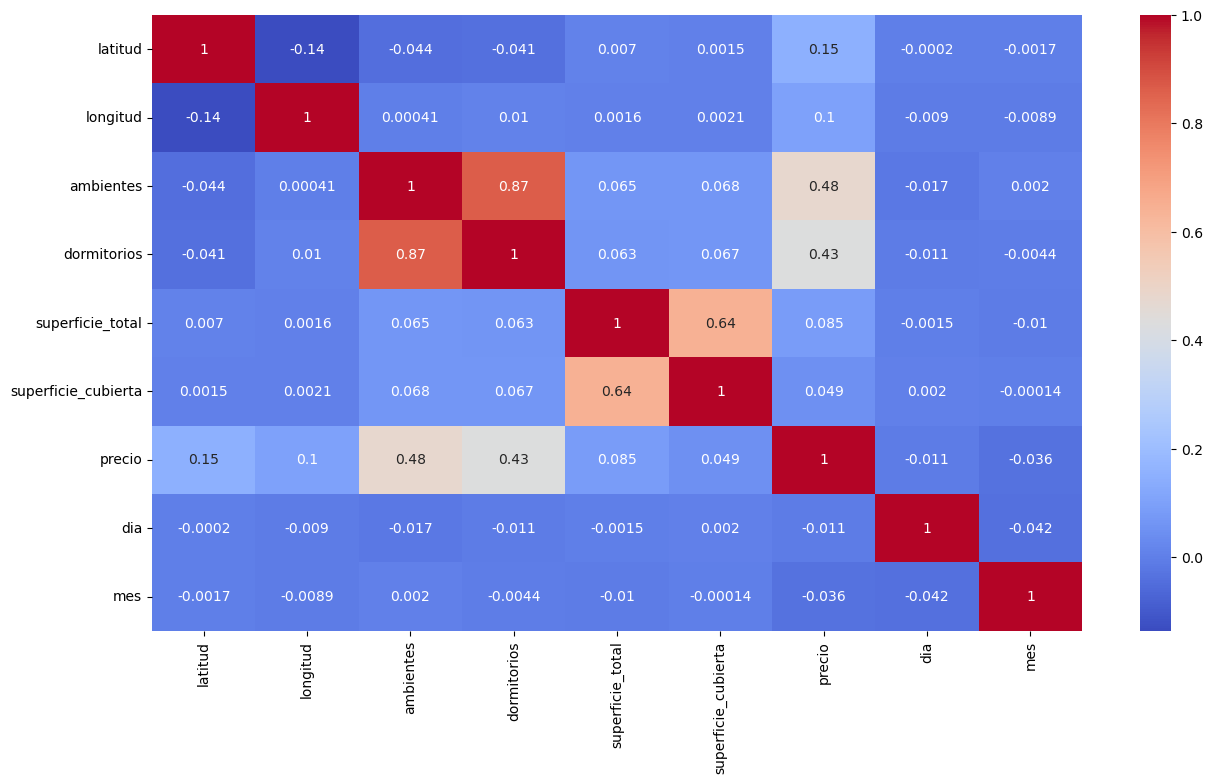

In [49]:
# Grafico la matriz de correlación en un Heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm")

Se ve cierta correlacion positiva media entre:
* Precio y Ambientes
* Precio y Dormitorios 

Naturalmente tambien vemos una correlacion mas fuerte entre:
* Superficie total y cubierta
* Ambientes y Dormitorios.

A continuacion exploremos estas correlaciones en mas detalle.

#### Dispersograma ambientes vrs precio

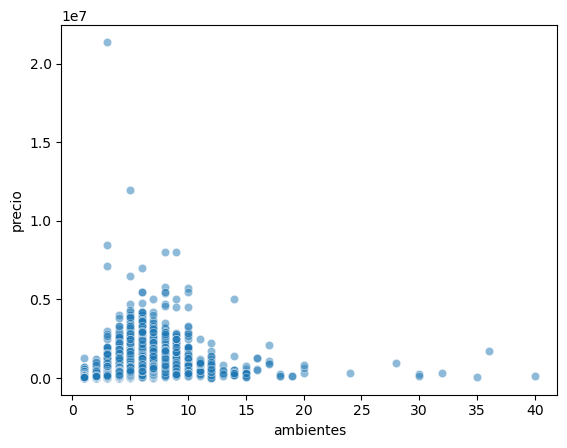

In [50]:
grf = sns.scatterplot(data=df, x="ambientes", y="precio", alpha=0.5)

#### Dispersograma dormitorios vrs precio

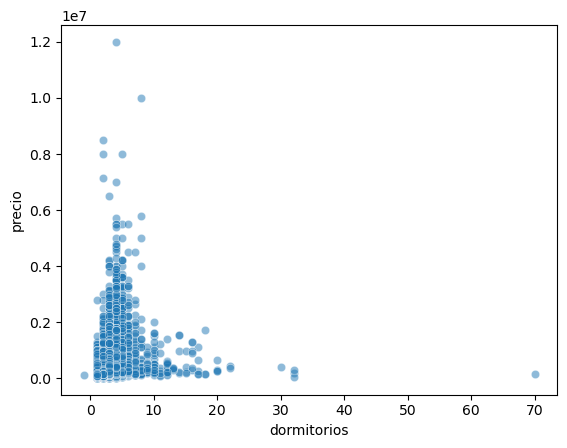

In [51]:
grf = sns.scatterplot(data=df, x="dormitorios", y="precio", alpha=0.5)

#### Dispersograma ambientes vrs superficie_total

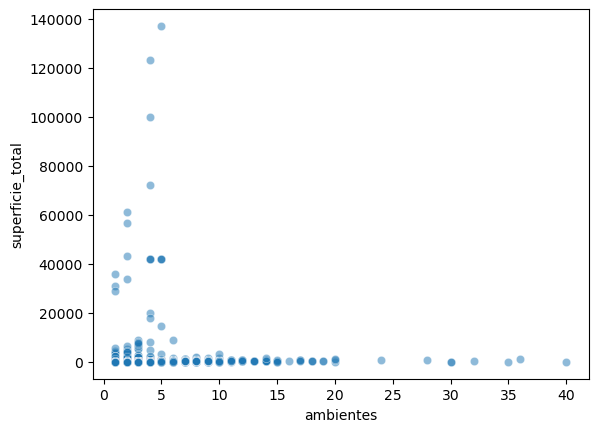

In [52]:
grf = sns.scatterplot(data=df, x="ambientes", y="superficie_total", alpha=0.5)

#### Dispersograma ambientes vrs superficie_cubierta

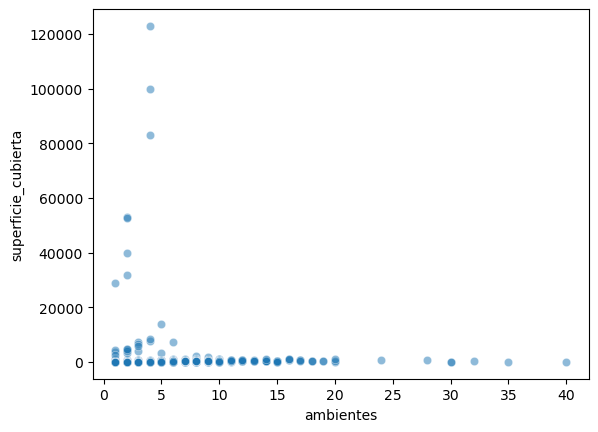

In [53]:
grf = sns.scatterplot(data=df, x="ambientes", y="superficie_cubierta", alpha=0.5)

#### Dispersograma ambientes vrs dormitorios

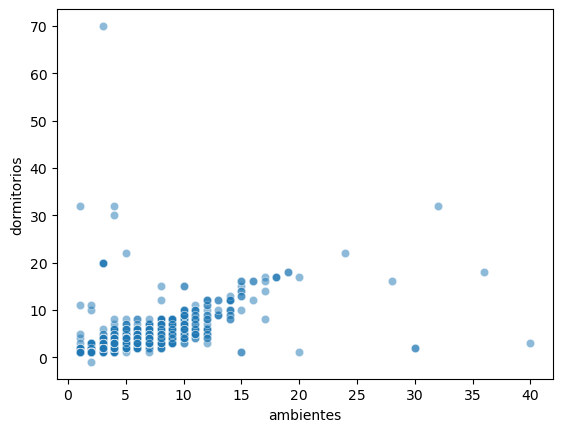

In [54]:
grf = sns.scatterplot(data=df, x="ambientes", y="dormitorios", alpha=0.5)

#### Dispersograma superficie_total vrs superficie_cubierta

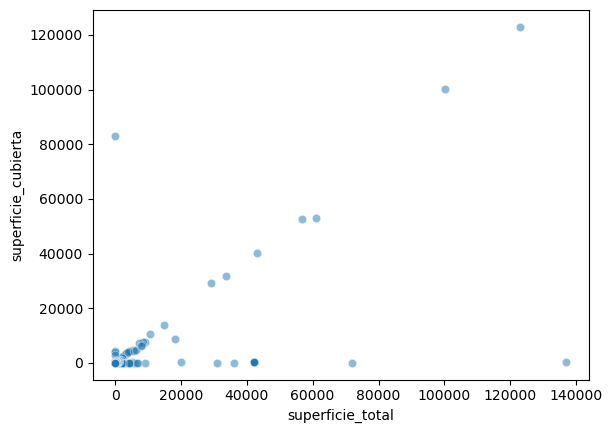

In [55]:
grf = sns.scatterplot(data=df, x="superficie_total", y="superficie_cubierta", alpha=0.5)

### Veamos la relacion entre algunos de los otros features

#### Dispersograma barrio vrs tipo

In [56]:
pd.crosstab(df["barrio"], df["tipo"])

tipo,Casa,Departamento,PH
barrio,,,
Abasto,5,192,5
Agronomía,26,108,86
Almagro,36,3140,317
Balvanera,19,2056,163
Barracas,81,842,182
Barrio Norte,19,2478,44
Belgrano,197,7013,202
Boca,23,268,49
Boedo,78,790,258


**c) Valores atípicos:** analizar la existencia de valores atípicos
* Detectar valores atípicos en los datos tanto en forma univariada como
multivariada. Realizar gráficos que permitan visualizar los valores atípicos.
* Explicar qué características poseen los datos atípicos detectados.
* Decidir el tratamiento a aplicar sobre los mismos.
* Analizar la relación entre el precio de venta y los metros de superficie ¿hay
valores atípicos que no se detectaron previamente?

### Precio

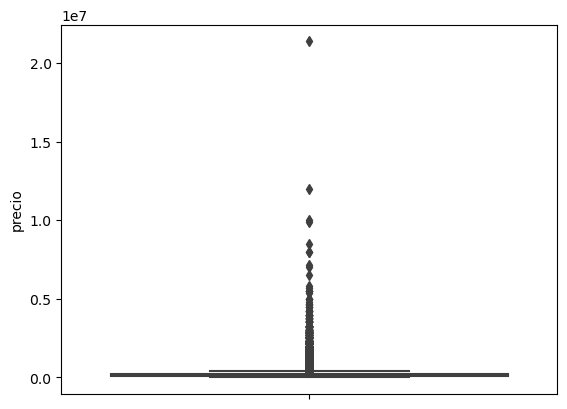

In [57]:
# sns.set(rc={"figure.figsize":(10, 45)})
sns.boxplot(y=df.precio)
plt.show()

Verificacion de valores atipicos

In [58]:
# Outliers
outlier = df[df["precio"] > 2500000]
outlier

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
48,-34.576741,-58.404830,Palermo,Departamento,NaN,4.0,400.0,NaN,2700000.0,9,9
197,-34.605781,-58.376705,San Nicolás,Departamento,NaN,NaN,10500.0,10500.0,9900000.0,9,9
872,-34.577484,-58.405751,Palermo,Departamento,5.0,3.0,535.0,220.0,2800000.0,20,9
886,-34.567172,-58.430634,Palermo,Departamento,5.0,4.0,390.0,390.0,2900000.0,20,9
1272,NaN,NaN,Palermo,Casa,NaN,4.0,550.0,480.0,2990000.0,9,2
...,...,...,...,...,...,...,...,...,...,...,...
75844,-34.574818,-58.421237,Palermo,Departamento,5.0,3.0,400.0,400.0,2890000.0,4,5
75847,-34.576855,-58.410590,Palermo,Departamento,8.0,4.0,489.0,454.0,2950000.0,4,5
80329,-34.581524,-58.403588,Palermo,Departamento,10.0,6.0,520.0,500.0,3300000.0,8,5
80514,NaN,NaN,Palermo,Casa,NaN,4.0,405.0,405.0,3200000.0,5,1


In [59]:
print(df["precio"].describe())

count    8.082300e+04
mean     2.143545e+05
std      2.855791e+05
min      5.000000e+03
25%      9.500000e+04
50%      1.400000e+05
75%      2.300000e+05
max      2.140000e+07
Name: precio, dtype: float64


Outliers viviendas segun precios

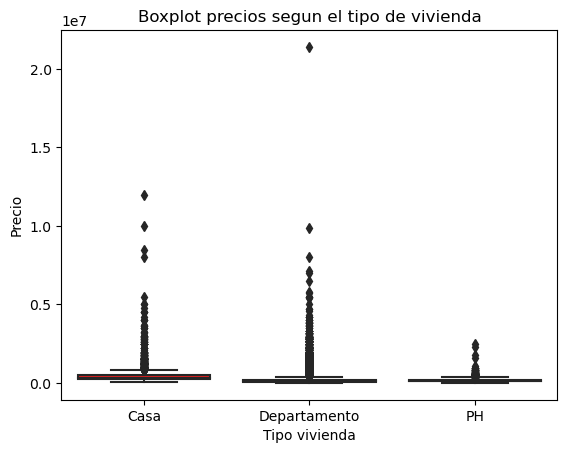

In [60]:
# Viviendas segun precios
# sns.set(rc={"figure.figsize":(10, 45)})
sns_boxplot_fare_pclass = sns.boxplot(
    x="tipo", y="precio", data=df, palette=["r", "b", "g"]
).set(
    title="Boxplot precios segun el tipo de vivienda",
    xlabel="Tipo vivienda",
    ylabel="Precio",
)

### Precio

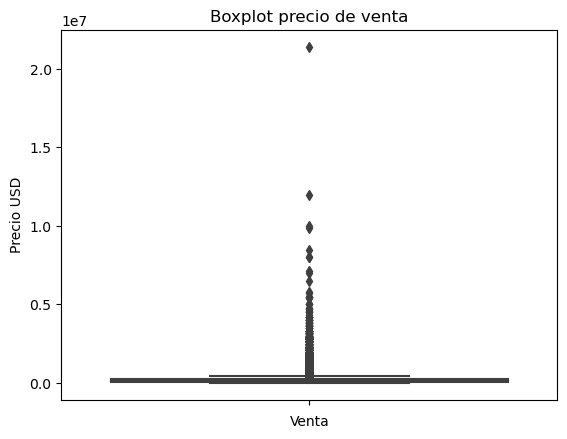

In [61]:
plt.figure(dpi=100)
sns_boxplot_price = sns.boxplot(y="precio", data=df).set(
    title="Boxplot precio de venta", xlabel="Venta", ylabel="Precio USD"
)

+ Outlier

In [62]:
df[df["precio"] > 20000000]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
11851,-34.616044,-58.458621,Caballito,Departamento,3.0,NaN,68.0,64.0,21400000.0,25,1


+ Es el mismo outlier de antes, es la venta de un departamento

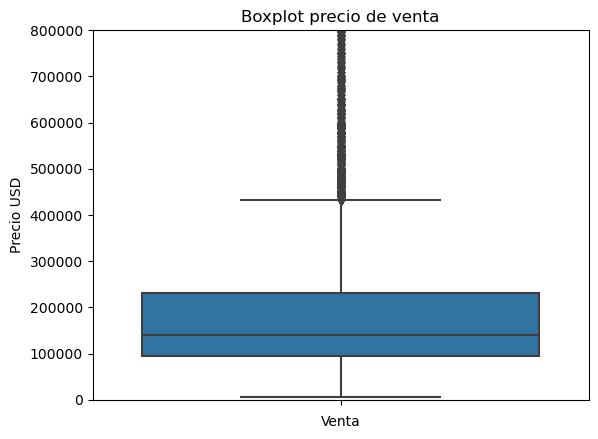

In [63]:
plt.figure(dpi=100)
sns_boxplot_price = sns.boxplot(y="precio", data=df)
sns_boxplot_price = sns_boxplot_price.set(
    title="Boxplot precio de venta",
    xlabel="Venta",
    ylabel="Precio USD",
    ylim=(0, 800000),
)

### Precio segun el tipo de propiedad

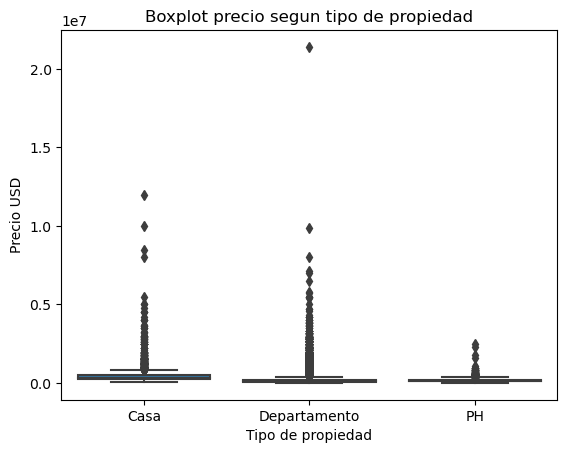

In [64]:
plt.figure(dpi=100)
sns_boxplot_price = sns.boxplot(x="tipo", y="precio", data=df).set(
    title="Boxplot precio segun tipo de propiedad",
    xlabel="Tipo de propiedad",
    ylabel="Precio USD",
)

+ Hay un outlier muy lejano en departamento

In [65]:
df_depto = df[df["tipo"] == "Departamento"]
df_depto[df_depto["precio"] > 20000000]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
11851,-34.616044,-58.458621,Caballito,Departamento,3.0,NaN,68.0,64.0,21400000.0,25,1


+ Hay 4 outliers mas alejados en casa

In [66]:
df_casa = df[df["tipo"] == "Casa"]
df_casa[df_casa["precio"] > 6000000]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
16853,-34.572494,-58.462433,Belgrano,Casa,5.0,4.0,3197.0,3367.0,12000000.0,26,3
28396,-34.565947,-58.442326,Belgrano,Casa,9.0,5.0,1763.0,1763.0,8000000.0,12,5
29732,-34.608300,-58.371200,Monserrat,Casa,3.0,2.0,225.0,93.0,8500000.0,17,2
59190,-34.593634,-58.377164,Retiro,Casa,NaN,8.0,1166.0,1485.0,10000000.0,17,9


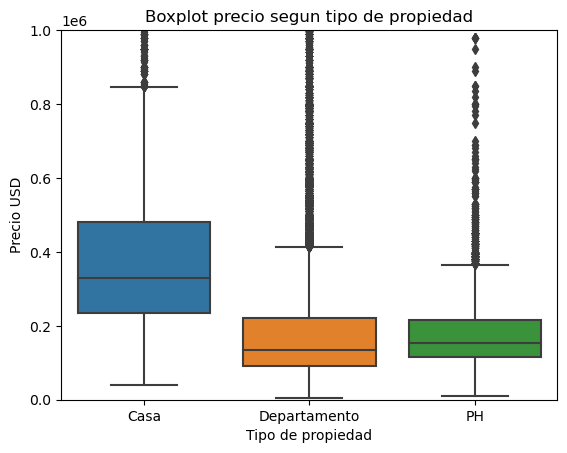

In [67]:
plt.figure(dpi=100)
sns_boxplot_price = sns.boxplot(x="tipo", y="precio", data=df)
sns_boxplot_price = sns_boxplot_price.set(
    title="Boxplot precio segun tipo de propiedad",
    xlabel="Tipo de propiedad",
    ylabel="Precio USD",
    ylim=(0, 1000000),
)

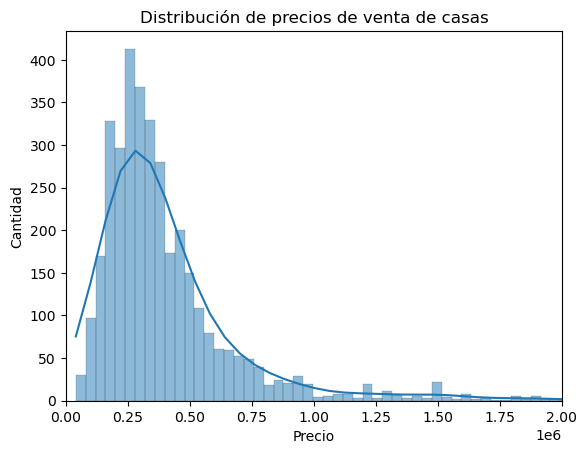

In [68]:
plt.figure(dpi=100)
h_casa = sns.histplot(df_casa["precio"], bins=300, kde=True)
h_casa = h_casa.set(
    title="Distribución de precios de venta de casas",
    xlim=(0, 2000000),
    xlabel="Precio",
    ylabel="Cantidad",
)

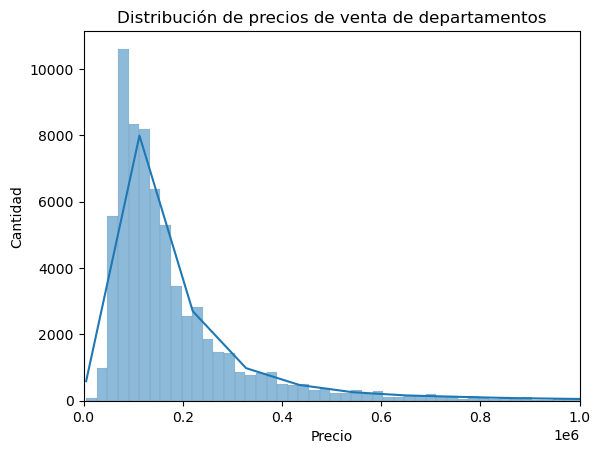

In [69]:
plt.figure(dpi=100)
h_depto = sns.histplot(df_depto["precio"], bins=1000, kde=True)
h_depto = h_depto.set(
    title="Distribución de precios de venta de departamentos",
    xlim=(0, 1000000),
    xlabel="Precio",
    ylabel="Cantidad",
)

In [70]:
df_ph = df[df["tipo"] == "PH"]

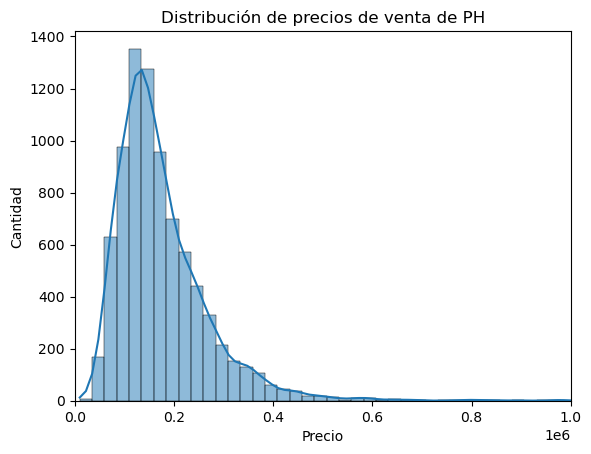

In [71]:
plt.figure(dpi=100)
h_ph = sns.histplot(df_ph["precio"], bins=100, kde=True)
h_ph = h_ph.set(
    title="Distribución de precios de venta de PH",
    xlim=(0, 1000000),
    xlabel="Precio",
    ylabel="Cantidad",
)

#### Con log

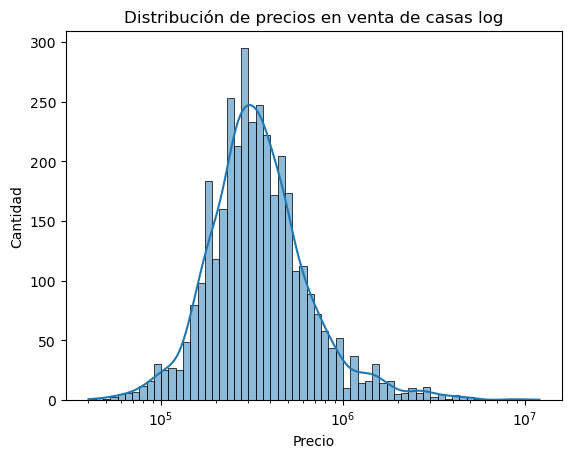

In [72]:
plt.figure(dpi=100)
h_casa2 = sns.histplot(df_casa["precio"], kde=True, log_scale=True)
h_casa2 = h_casa2.set(
    title="Distribución de precios en venta de casas log",
    xlabel="Precio",
    ylabel="Cantidad",
)

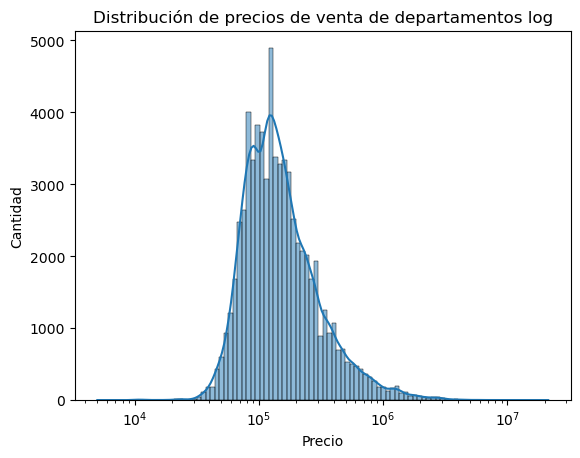

In [73]:
plt.figure(dpi=100)
h_depto2 = sns.histplot(df_depto["precio"], bins=100, kde=True, log_scale=True)
h_depto2 = h_depto2.set(
    title="Distribución de precios de venta de departamentos log",
    xlabel="Precio",
    ylabel="Cantidad",
)

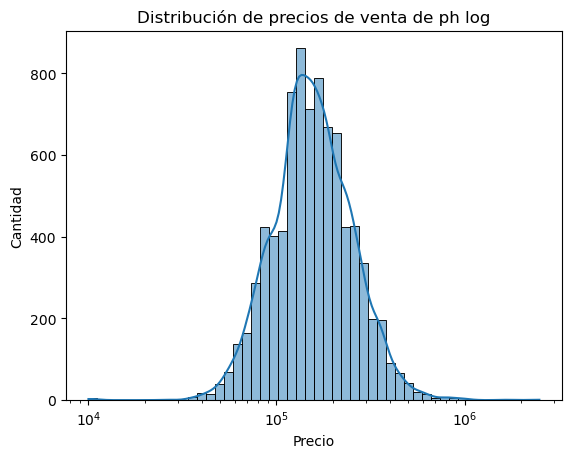

In [74]:
plt.figure(dpi=100)
h_ph2 = sns.histplot(df_ph["precio"], bins=50, kde=True, log_scale=True)
h_ph2 = h_ph2.set(
    title="Distribución de precios de venta de ph log",
    xlabel="Precio",
    ylabel="Cantidad",
)

#### Ambientes

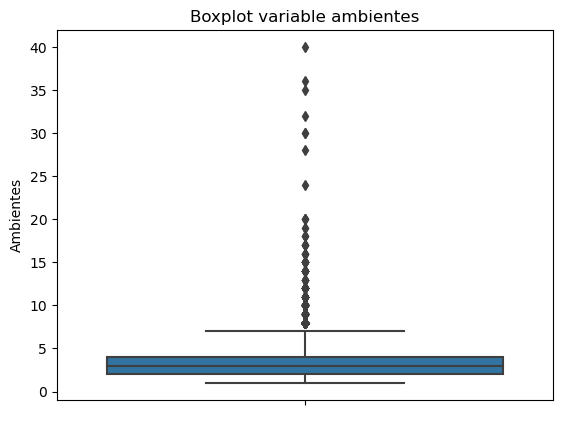

In [75]:
# Boxplot de la variable ambientes
grf_box = sns.boxplot(y="ambientes", data=df).set(
    title="Boxplot variable ambientes", xlabel=" ", ylabel="Ambientes"
)

Podemos observar multiples outliers, muchos de ellos extremos

In [76]:
outlier_rooms = df[df.ambientes > 25]
outlier_rooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
4134,-34.616391,-58.456038,Caballito,Departamento,30.0,2.0,79.0,79.0,230000.0,15,3
10137,-34.649872,-58.483012,Parque Avellaneda,PH,30.0,2.0,72.0,60.0,123500.0,7,2
17648,-34.633236,-58.480313,Floresta,PH,32.0,32.0,535.0,435.0,300000.0,3,8
28273,NaN,NaN,Tribunales,Departamento,36.0,18.0,1348.0,NaN,1700000.0,19,8
28902,-34.642037,-58.438995,Parque Chacabuco,Departamento,35.0,NaN,37.0,33.0,67000.0,24,3
62951,-34.588742,-58.422459,Palermo,Departamento,40.0,3.0,75.0,68.0,145000.0,18,11
68131,-34.570959,-58.458106,Belgrano,Casa,28.0,16.0,845.0,845.0,950000.0,5,5


Vemos que salvo el hotel y la casa inglesa, los demas no son posibles. Procedemos a borrarlos.

In [77]:
# Seleccionamos todos menos el hotel y la casa inglesa
idx = outlier_rooms.iloc[[2,5],].index
# Y los eliminamos
df.drop(idx, inplace=True)

Volvamos a ver el boxplot luego de eliminar los outliers.

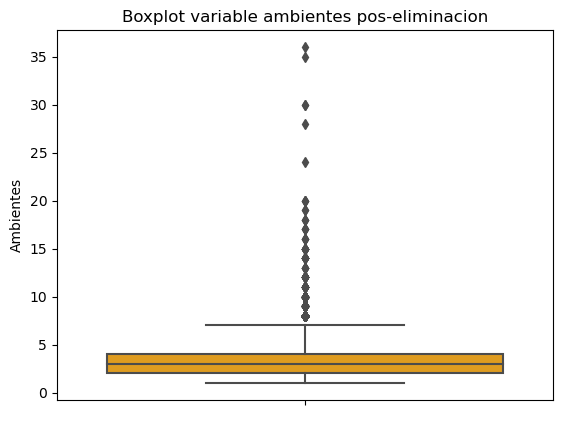

In [78]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="ambientes", data=df, color='orange').set(
    title="Boxplot variable ambientes pos-eliminacion", xlabel=" ", ylabel="Ambientes"
)

#### Dormitorios

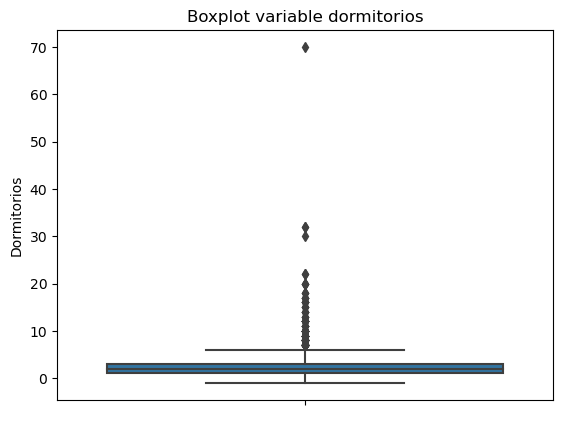

In [79]:
# Boxplot de la variable dormitorios
grf_box = sns.boxplot(y="dormitorios", data=df).set(
    title="Boxplot variable dormitorios", xlabel=" ", ylabel="Dormitorios"
)

Nuevamente vemos multiples outliers, algunos de ellos extremos.

In [80]:
outlier_bedrooms = df[df.dormitorios > 25]
outlier_bedrooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
9404,-34.608645,-58.485619,Villa del Parque,Departamento,4.0,32.0,83.0,75.0,189000.0,14,3
9719,-34.630186,-58.389156,Parque Patricios,Departamento,1.0,32.0,32.0,32.0,52000.0,16,10
16937,-34.591110,-58.400685,Recoleta,Departamento,4.0,30.0,148.0,138.0,380000.0,26,3
18643,-34.646632,-58.497902,Villa Luro,Departamento,3.0,70.0,NaN,70.0,135000.0,24,9


Vemos que ninguno de los casos es posible. Procedemos a eliminarlos.

In [81]:
# Seleccionamos todos menos el hotel
idx = outlier_bedrooms.index
# Y los eliminamos
df.drop(idx, inplace=True)

Nos fijamos nuevamente en el boxplot luego de la eliminacion de los outliers extremos.

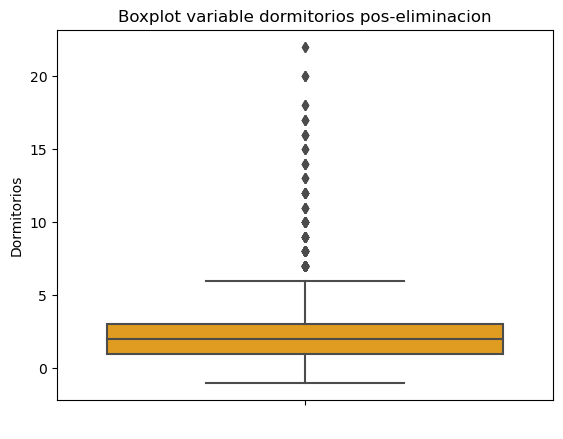

In [82]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="dormitorios", data=df, color='orange').set(
    title="Boxplot variable dormitorios pos-eliminacion", xlabel=" ", ylabel="Dormitorios"
)

#### Superficie Total

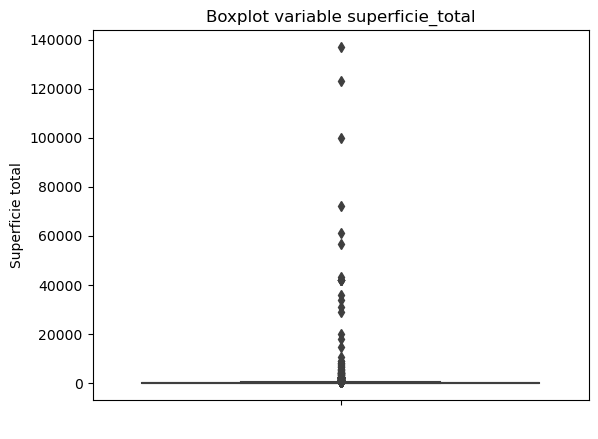

In [83]:
# Boxplot de la variable superficie total
grf_box = sns.boxplot(y="superficie_total", data=df).set(
    title="Boxplot variable superficie_total", xlabel=" ", ylabel="Superficie total"
)

Se observa una gran cantidad de outliers y muy extremos

In [84]:
# Buscamos observaciones mayores a 5mil m2
outlier_sfc_total = df[df.superficie_total > 5000]
# Verificamos si son valores posibles
outlier_sfc_total

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
197,-34.605781,-58.376705,San Nicolás,Departamento,NaN,NaN,10500.0,10500.0,9900000.0,9,9
14297,-34.578917,-58.429373,Palermo,Departamento,2.0,1.0,61130.0,53030.0,225000.0,29,5
14363,-34.600113,-58.403649,Balvanera,Departamento,2.0,1.0,33800.0,31670.0,66000.0,29,5
16565,-34.588175,-58.396261,Recoleta,Departamento,1.0,NaN,36000.0,30.0,90000.0,5,2
18609,-34.614279,-58.361092,Caballito,Departamento,2.0,1.0,5312.0,4809.0,145000.0,24,9
20621,-34.587320,-58.401556,Barrio Norte,Departamento,2.0,1.0,56740.0,52540.0,175000.0,11,3
22875,-34.550093,-58.483034,Saavedra,Departamento,2.0,1.0,43086.0,40038.0,114000.0,18,8
24603,-34.579163,-58.455725,Colegiales,Departamento,1.0,NaN,31000.0,26.0,51100.0,5,10
24930,-34.599421,-58.386867,Barrio Norte,Departamento,5.0,3.0,137000.0,135.0,390000.0,1,7
28682,-34.629203,-58.437124,Caballito,PH,3.0,2.0,5736.0,57.0,169000.0,24,3


In [85]:
# Vemos que hay valores que posiblemente tengan ceros de mas
idx = outlier_sfc_total.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

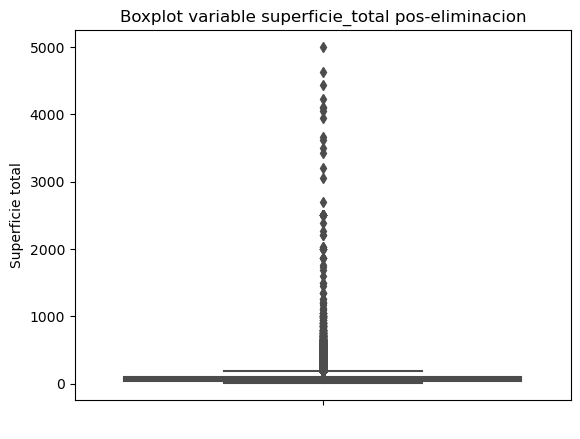

In [86]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="superficie_total", data=df, color='orange').set(
    title="Boxplot variable superficie_total pos-eliminacion", xlabel=" ", ylabel="Superficie total"
)

Elegimos un umbral que nos parezca razonable, despues de haber visto mejor los datos, para buscar outliers invalidos.

In [87]:
# Buscamos observaciones mayores a mil m2 pero menos de 5 ambientes
outlier_sfc_rooms = df[
    df.apply(
        lambda x: x["superficie_total"] > 1000
        and x["ambientes"] < 5,
        axis=1,
    )
]
# Verificamos si son valores posibles
outlier_sfc_rooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
357,-34.584521,-58.424260,Palermo,Departamento,2.0,1.0,2032.0,37.0,87000.0,17,12
6490,-34.634196,-58.465152,Flores,Departamento,1.0,1.0,4428.0,31.0,58552.0,8,2
6700,-34.554356,-58.458076,Belgrano,Departamento,2.0,1.0,2500.0,51.0,189850.0,8,2
6709,-34.557903,-58.452293,Belgrano,Departamento,4.0,3.0,5000.0,109.0,418000.0,8,2
6796,-34.611660,-58.393440,Balvanera,Departamento,2.0,1.0,2383.0,37.0,64000.0,8,2
6840,-34.628565,-58.445791,Caballito,Departamento,4.0,3.0,2000.0,162.0,449900.0,8,2
7024,-34.573000,-58.481100,Villa Urquiza,Departamento,1.0,NaN,3660.0,33.0,98000.0,8,2
7026,-34.573375,-58.480012,Villa Urquiza,Departamento,2.0,1.0,3500.0,60.0,169000.0,8,2
11648,-34.563005,-58.453674,Belgrano,Departamento,3.0,2.0,2500.0,66.0,289500.0,13,3
11654,-34.563005,-58.453674,Belgrano,Departamento,3.0,2.0,2500.0,66.0,299900.0,13,3


In [88]:
# Vemos que hay valores que posiblemente tengan ceros de mas
idx = outlier_sfc_rooms.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

Volvemos a realizar el mismo proceso, con un nuevo umbral para intentar detectar otros outliers invalidos.

In [89]:
# Buscamos observaciones mayores a 500 m2 pero menos de 4 ambientes
outlier_sfc_rooms = df[
    df.apply(
        lambda x: x["superficie_total"] > 500
        and x["ambientes"] < 4,
        axis=1,
    )
]
# Verificamos si son valores posibles
outlier_sfc_rooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
9415,-34.613200,-58.471100,Villa General Mitre,PH,3.0,4.0,800.0,720.0,495000.0,15,8
27422,-34.646590,-58.519538,Liniers,PH,3.0,2.0,534.0,340.0,440000.0,8,6
34794,-34.621995,-58.508856,Floresta,Departamento,3.0,2.0,645.0,59.0,93000.0,7,8
41468,-34.580700,-58.413795,Palermo,Departamento,2.0,1.0,725.0,65.0,349000.0,9,1
41884,-34.580496,-58.429956,Palermo,Casa,1.0,NaN,1000.0,900.0,300000.0,8,3
42908,-34.607533,-58.477092,Villa General Mitre,Departamento,3.0,2.0,560.0,416.0,499900.0,20,3
76793,-34.617351,-58.499418,Monte Castro,Casa,3.0,2.0,525.0,355.0,400000.0,23,4
80526,-34.645581,-58.472496,Parque Avellaneda,Casa,3.0,2.0,526.0,474.0,400000.0,5,1


In [90]:
# Vemos que hay valores que posiblemente tengan ceros de mas
idx = outlier_sfc_rooms.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

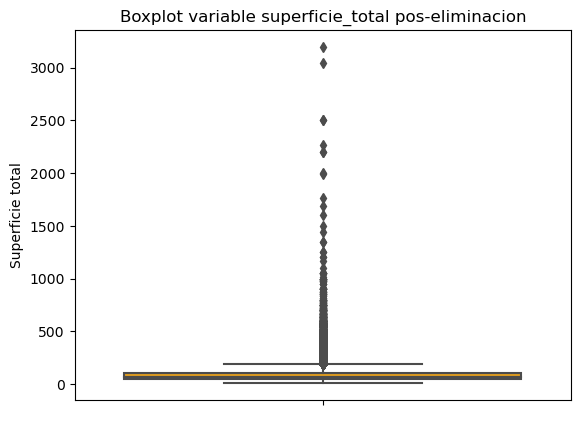

In [91]:
# Volvemos a graficar un boxplot una ultima vez luego de eliminar mas propiedades
grf_box = sns.boxplot(y="superficie_total", data=df, color='orange').set(
    title="Boxplot variable superficie_total pos-eliminacion", xlabel=" ", ylabel="Superficie total"
)

#### Superficie Cubierta

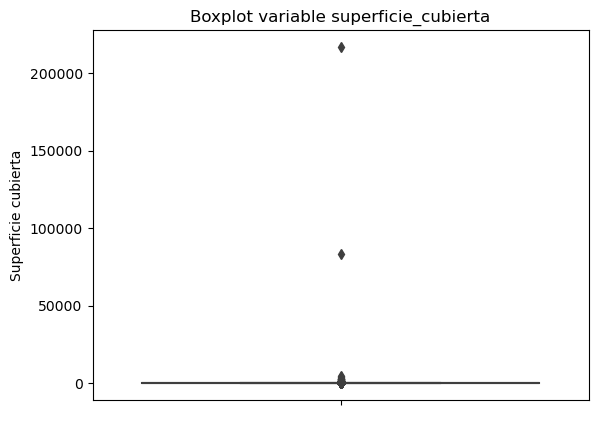

In [92]:
# Boxplot de la variable superficie cubierta
grf_box = sns.boxplot(y="superficie_cubierta", data=df).set(
    title="Boxplot variable superficie_cubierta",
    xlabel=" ",
    ylabel="Superficie cubierta",
)

In [93]:
# Buscamos observaciones mayores a 3mil m2
outlier_sfc_cov = df[df.superficie_cubierta > 3000]
outlier_sfc_cov

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
304,-34.637026,-58.426283,Parque Chacabuco,Casa,NaN,NaN,NaN,217000.0,250000.0,17,12
6011,NaN,NaN,San Telmo,Departamento,2.0,1.0,48.0,4435.0,93500.0,15,10
16853,-34.572494,-58.462433,Belgrano,Casa,5.0,4.0,3197.0,3367.0,12000000.0,26,3
37200,-34.604362,-58.392366,Barrio Norte,Departamento,4.0,NaN,83.0,83000.0,155000.0,25,7
62629,-34.579394,-58.453519,Colegiales,Departamento,3.0,2.0,41.0,3837.0,83000.0,4,11


In [94]:
# Vemos que hay valores que posiblemente tengan ceros de mas
idx = outlier_sfc_cov.index
# Y procedemos a borrarlos, mas adelante se podria intentar salvarlos
df.drop(idx, inplace=True)

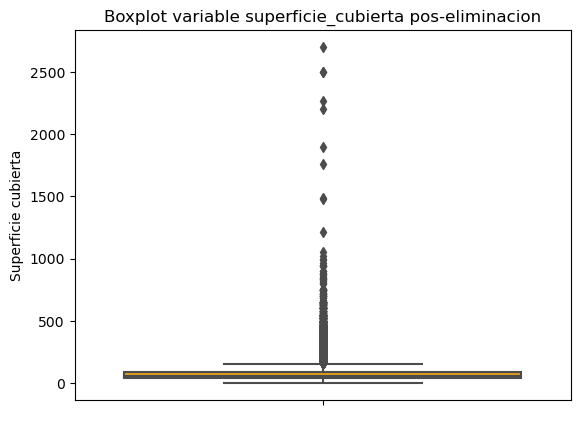

In [95]:
# Volvemos a graficar un boxplot despues de eliminar algunos outliers
grf_box = sns.boxplot(y="superficie_cubierta", data=df, color='orange').set(
    title="Boxplot variable superficie_cubierta pos-eliminacion",
    xlabel=" ",
    ylabel="Superficie cubierta",
)

In [96]:
# Buscamos observaciones mayores a mil m2 cubiertos pero menos de 5 ambientes
outlier_covsfc_rooms = df[
    df.apply(
        lambda x: x["superficie_cubierta"] > 1000
        and x["ambientes"] < 5,
        axis=1,
    )
]
# Verificamos si son valores posibles
outlier_covsfc_rooms

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes
76588,-34.630704,-58.400901,Parque Patricios,Departamento,1.0,NaN,31.0,2700.0,71500.0,27,10


In [97]:
# Vemos que hay un valor que no es posible
idx = outlier_covsfc_rooms.index
# Y procedemos a borrarlo
df.drop(idx, inplace=True)

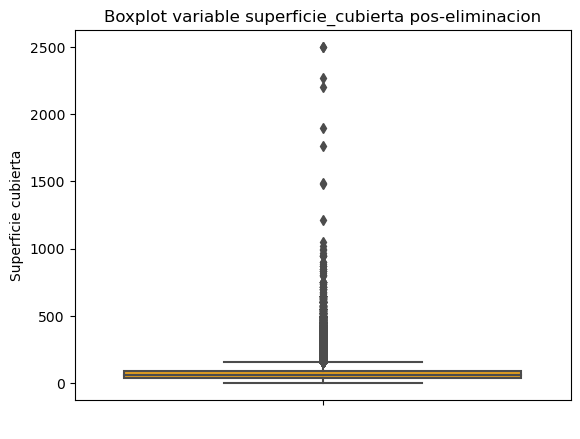

In [98]:
# Volvemos a graficar un boxplot una ultima despues de eliminar algunos outliers
grf_box = sns.boxplot(y="superficie_cubierta", data=df, color='orange').set(
    title="Boxplot variable superficie_cubierta pos-eliminacion",
    xlabel=" ",
    ylabel="Superficie cubierta",
)

**b) Datos Faltantes:** analizar la presencia de datos faltantes en el dataset
* Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset
* Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de
datos faltantes de cada registro. Realizar un gráfico que permita conocer la
proporción de faltantes por fila en el dataset.
* Determinar, de ser posible, estrategias para reparar los valores faltantes.
* En caso de realizar imputaciones comparar las distribuciones de cada atributo
reparado con la distribución anterior a la imputación de los datos faltantes.

<h4 align="center"><b> Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset </b></h4>

#### Veamos la distribucion de datos faltantes del dataset en general

In [99]:
na_ratio_column = pd.DataFrame()
na_ratio_column["Percent"] = ((df.isnull().sum() / len(df)) * 100).sort_values(
    ascending=False
)
na_ratio_column["Count"] = (df.isnull().sum()).sort_values(ascending=False)

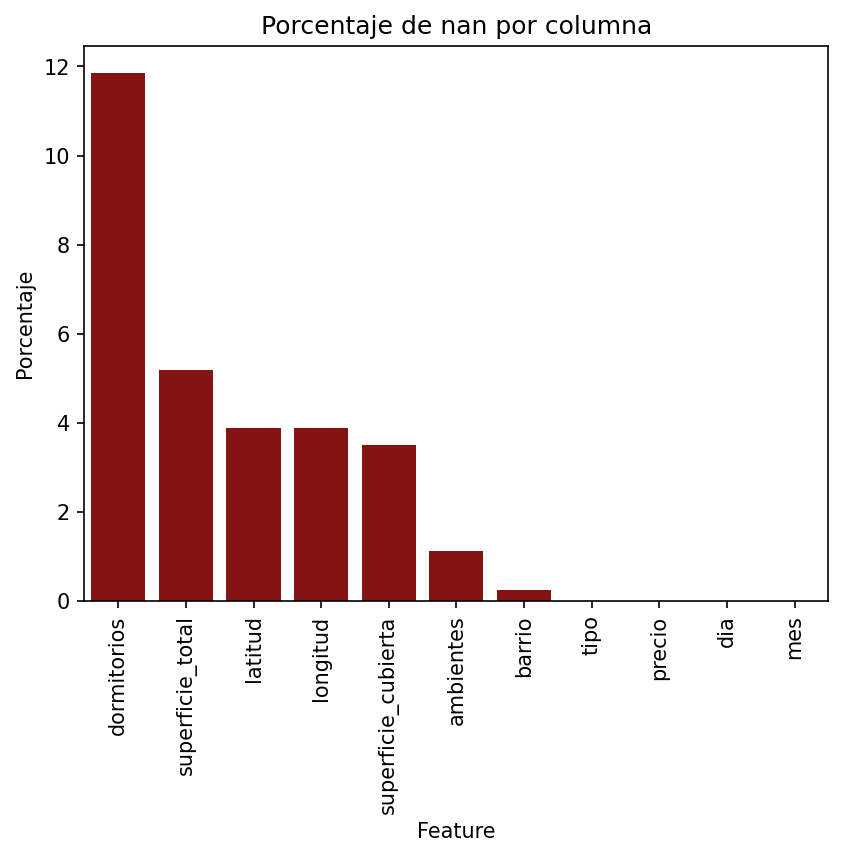

In [100]:
eje_x = na_ratio_column.index
eje_y = list(na_ratio_column["Percent"])

plt.figure(dpi=150)
sns_bar_plot = sns.barplot(x=eje_x, y=eje_y, color=(0.6, 0, 0), alpha=1)
plt.ylabel("Porcentaje")
plt.xlabel("Feature")
plt.title("Porcentaje de nan por columna")
plt.xticks(rotation=90)
plt.show()

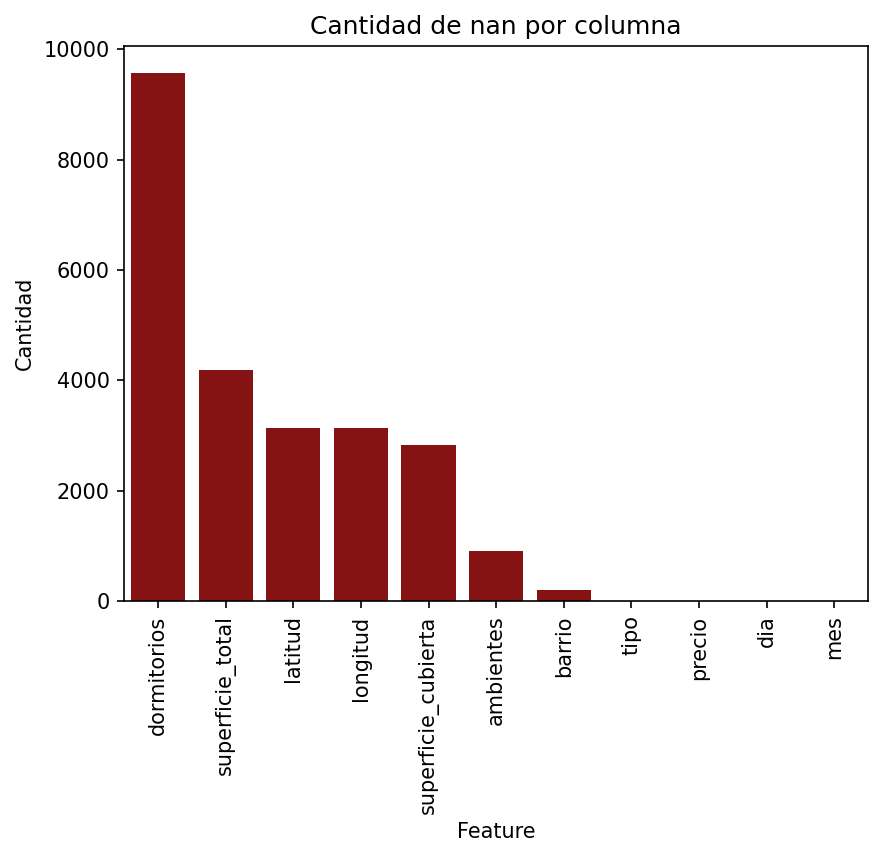

In [101]:
eje_x = na_ratio_column.index
eje_y = list(na_ratio_column["Count"])

plt.figure(dpi=150)
sns_bar_plot = sns.barplot(x=eje_x, y=eje_y, color=(0.6, 0, 0), alpha=1)
plt.ylabel("Cantidad")
plt.xlabel("Feature")
plt.title("Cantidad de nan por columna")
plt.xticks(rotation=90)
plt.show()

Vemos que los features con mayor porcentaje de datos faltantes son:
* sub_barrio
* dormitorios
* superficie_total
* latitud
* longitud
* superficie_cubierta
* ambientes

En ese orden, con sub_barrio teniendo la particularidad de estar casi 100% vacio.

<h4 align="center"><b> Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de datos faltantes de cada registro. Realizar un gráfico que permita conocer la proporción de faltantes por fila en el dataset </b></h4>

In [102]:
na_ratio_row = pd.DataFrame()
n_column = df.shape[1]
na_ratio_row["Percent"] = df.isnull().sum(axis=1) / n_column
na_ratio_row["Count"] = df.isnull().sum(axis=1)

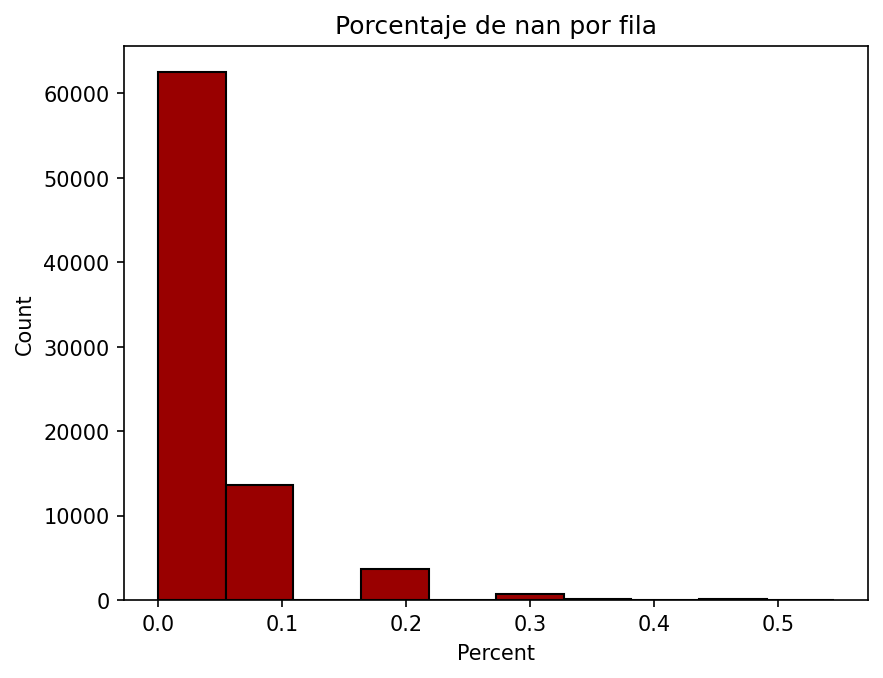

In [103]:
plt.figure(dpi=150)
sns.histplot(data=na_ratio_row, x="Percent", bins=10, color=(0.6, 0, 0), alpha=1)
plt.title("Porcentaje de nan por fila")
plt.show()

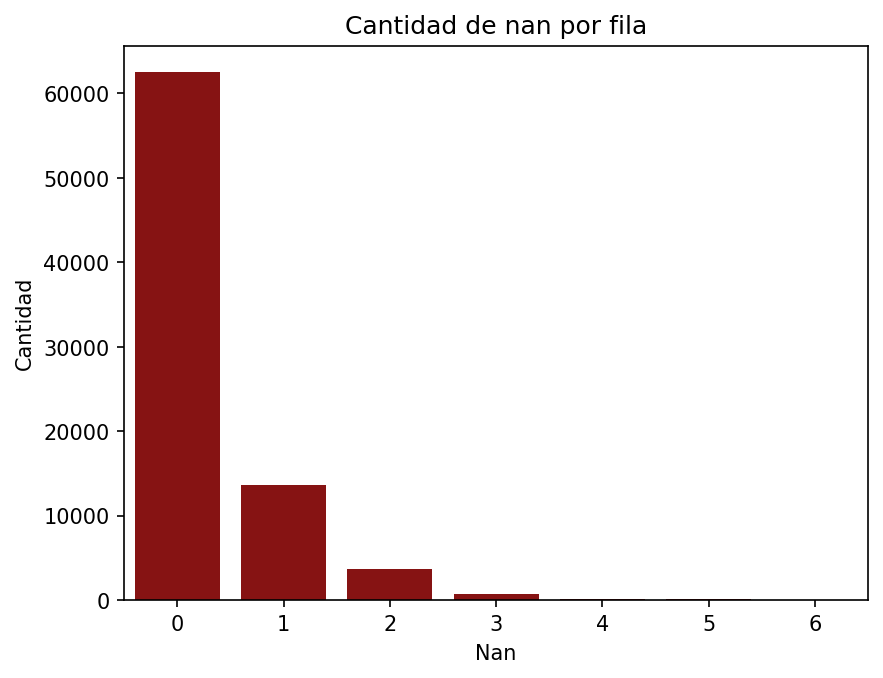

In [104]:
plt.figure(dpi=150)
sns.countplot(x="Count", data=na_ratio_row, color=(0.6, 0, 0), alpha=1)
plt.ylabel("Cantidad")
plt.xlabel("Nan")
plt.title("Cantidad de nan por fila")
plt.show()

#### Barrios

In [105]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
barrios_nan=round(df.isna().barrio.sum() / filas_totales * 100, 3)
print(f"El feature Barrios tiene: {barrios_nan} % filas nulas")

El feature Barrios tiene: 0.253 % filas nulas


Como el porcentaje de NaNs de place_l3 en relacion a las filas totales es del 0.54 ,eliminamos dichos registros

In [106]:
df = df[df["barrio"].notna()]

#### Ambientes

In [107]:
# Vemos cuantas filas tienen datos faltantes de ambientes
ambs_nan=df.ambientes.isnull().sum()
ambs_nan

875

In [108]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(f"El feature Ambientes tiene: {round(ambs_nan / filas_totales * 100, 3)} % filas nulas")

El feature Ambientes tiene: 1.087 % filas nulas


In [109]:
# Borramos las filas vacias
idx = df[df.ambientes.isnull()].index
df.drop(idx, inplace=True)

In [110]:
# Vemos si hay valores negativos
(df.ambientes <= 0).any()

False

Al tener un porcentaje relativamente pequeno de datos faltantes decidimos borrar los mismo en el feature Ambientes

#### Dormitorios

In [111]:
# Vemos cuantas filas tienen datos faltantes de dormitorios
dorms_nan=df.dormitorios.isnull().sum()
dorms_nan

9059

In [112]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(f"El feature Dormitorios tiene: {round(dorms_nan / filas_totales * 100, 3)} % filas nulas")

El feature Dormitorios tiene: 11.374 % filas nulas


In [113]:
# Vemos si hay valores negativos
(df.dormitorios <= 0).sum()

1

Encontramos un valor negativo, y lo borramos.

In [114]:
# Borramos el valor negativo
idx = df[df.dormitorios <= 0].index
df.drop(idx, inplace=True)

In [115]:
# Vemos cuantas propiedades tienen mas dormitorios que ambientes, lo cual no tiene sentido
df.apply(
    lambda row: True if row["ambientes"] < row["dormitorios"] else False, axis=1
).sum()

120

In [116]:
# Borramos las propiedades con mas dormitorios que ambientes
idx = df[
    df.apply(
        lambda row: True if row["ambientes"] < row["dormitorios"] else False, axis=1
    )
].index
df.drop(idx, inplace=True)

Por tener una cantidad considerablemente mayor de datos faltantes que el feature Ambientes y estar directamente relacionado con este, decidimos dejar los datos faltantes del feature Dormitorios e intentar repararlos mas adelante.

#### Superficie Total

In [117]:
# Vemos cuantas filas tienen datos faltantes de superficie_total
sup_total_nan=df.superficie_total.isnull().sum()
sup_total_nan

3933

In [118]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(f"El feature Superficie Total tiene: {round(sup_total_nan / filas_totales * 100, 3)} % filas nulas")

El feature Superficie Total tiene: 4.945 % filas nulas


In [119]:
# Borramos las filas vacias
idx = df[df.superficie_total.isnull()].index
df.drop(idx, inplace=True)

In [120]:
# Vemos si hay valores negativos
(df.superficie_total <= 0).any()

False

Nos encontramos con menos del 5% del Dataset con datos nulos, al ser un porcentaje pequeno procedemos a borrarlos ya que es una feature relevante a nuestro target.

#### Superficie Cubierta

In [121]:
# Vemos cuantas filas tienen datos faltantes de superficie_cubierta
sup_cub_nan=df.superficie_cubierta.isnull().sum()
sup_cub_nan

2728

In [122]:
filas_totales = df.shape[0]
# Calculamos el porcentaje de filas nulas respecto del total de filas
print(f"El feature Superficie Cubierta tiene: {round(sup_cub_nan / filas_totales * 100, 3)} % filas nulas")

El feature Superficie Cubierta tiene: 3.609 % filas nulas


In [123]:
# Borramos las filas vacias
idx = df[df.superficie_cubierta.isnull()].index
df.drop(idx, inplace=True)

In [124]:
# Vemos si hay valores negativos
(df.superficie_cubierta <= 0).any()

False

In [125]:
# Vemos cuantas propiedades tienen mas superficie cubierta que total, lo cual no tiene sentido
df.apply(
    lambda row: True if row["superficie_total"] < row["superficie_cubierta"] else False,
    axis=1,
).sum()

159

In [126]:
# Borramos las propiedades con mas superficie cubierta que total
idx = df[
    df.apply(
        lambda row: True
        if row["superficie_total"] < row["superficie_cubierta"]
        else False,
        axis=1,
    )
].index
df.drop(idx, inplace=True)

#### Vamos a verificar que las propiedades que tenemos esten efectivamente dentro de los limites de Capital Federal, esta vez de manera mas exhaustiva:

In [127]:
import geopandas as geopd
import rtree
from geopandas.tools import sjoin
from shapely.geometry import Polygon, LineString, Point

In [128]:
# Armamos un geodatafreame pasando longitud y latitud a variable de tipo punto
gdf = geopd.GeoDataFrame(
    df, geometry=geopd.points_from_xy(df.longitud, df.latitud))

df=gdf

In [129]:
df[df.latitud.isna()]

,latitud,longitud,barrio,tipo,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,dia,mes,geometry
44,NaN,NaN,Palermo,Departamento,3.0,2.0,85.0,85.0,200000.0,9,9,POINT EMPTY
72,NaN,NaN,Palermo,Departamento,2.0,1.0,50.0,50.0,153000.0,9,9,POINT EMPTY
73,NaN,NaN,Palermo,Departamento,3.0,2.0,185.0,185.0,890000.0,9,9,POINT EMPTY
97,NaN,NaN,Belgrano,Departamento,4.0,3.0,180.0,103.0,495000.0,9,9,POINT EMPTY
102,NaN,NaN,Floresta,Casa,5.0,4.0,165.0,115.0,185000.0,9,9,POINT EMPTY
...,...,...,...,...,...,...,...,...,...,...,...,...
80672,NaN,NaN,Recoleta,Departamento,8.0,5.0,256.0,256.0,800000.0,5,1,POINT EMPTY
80708,NaN,NaN,Recoleta,Departamento,6.0,4.0,169.0,159.0,450000.0,5,1,POINT EMPTY
80770,NaN,NaN,Barrio Norte,Departamento,3.0,2.0,115.0,108.0,310000.0,5,1,POINT EMPTY
80771,NaN,NaN,Barrio Norte,Departamento,3.0,2.0,54.0,50.0,165000.0,5,1,POINT EMPTY


In [130]:
# Tomamos los limites de Capital Federal
url='https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/perimetro/perimetro.geojson'
perimetro = geopd.read_file(url)
# perimetro = geopd.read_file("./Datasets/perimetro.geojson")
df_perimetro = perimetro.copy()
df_perimetro=df_perimetro.filter(['geometry'])
# Nos guardamos el tamanio previo a eliminar las propiedad que estan afuera de los limites
tam_precheck=df.shape[0]

In [131]:
# Unimos los datasets, lo cual nos deja solamente con las viviendas que caigan en los limites de la ciudad
df.set_crs('EPSG:4326', inplace=True)
df = df.sjoin(df_perimetro,how='left')

In [132]:
# Borramos las filas que no caian dentro de los limites de la ciudad, pero sin borrar las que tenian sus coordenadas en NaN
df=df[~((df.index_right.isna()) & ~(df.geometry.is_empty))]
df.drop(columns='index_right', inplace=True)

Calculemos cuantas filas perdimos:

In [133]:
tam_final=df.shape[0]
print(f"Se eliminaron: {tam_precheck-tam_final} filas despues de verificar coordenadas, lo cual representa un {round((tam_precheck-tam_final) / tam_precheck * 100, 3)}%")

Se eliminaron: 5 filas despues de verificar coordenadas, lo cual representa un 0.007%


<h4 align="center"><b> Estudiamos la target </b></h4>

Mostramos la distribución del precio por metro cuadrado

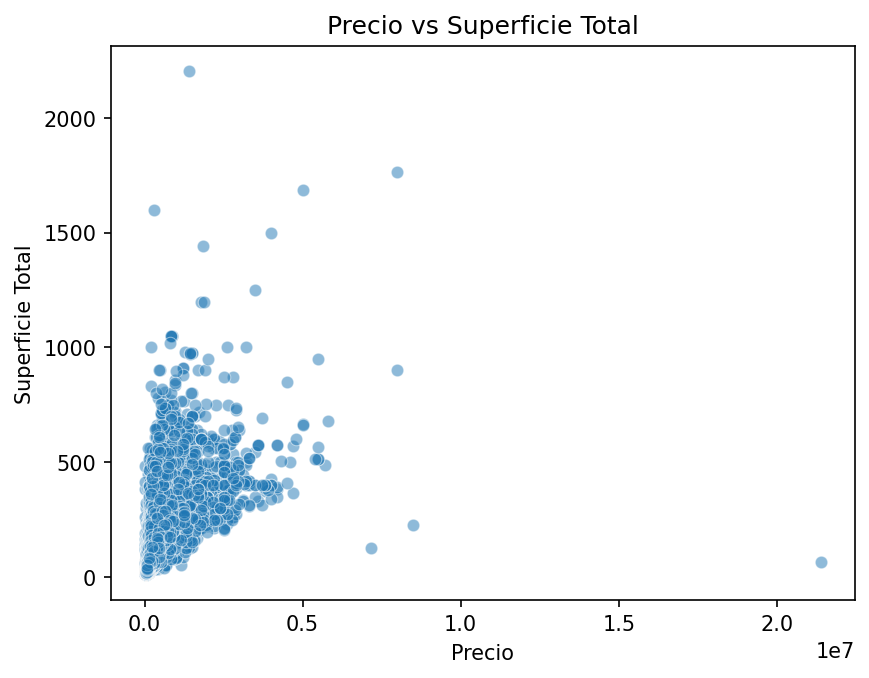

In [134]:
plt.figure(dpi=150)
grf = sns.scatterplot(data=df, x="precio", y="superficie_total", alpha=0.5)
grf = grf.set(
    title="Precio vs Superficie Total",
    xlabel="Precio",
    ylabel="Superficie Total",
)

Mostramos la distribución del precio por metro cuadrado por tipo de propiedad

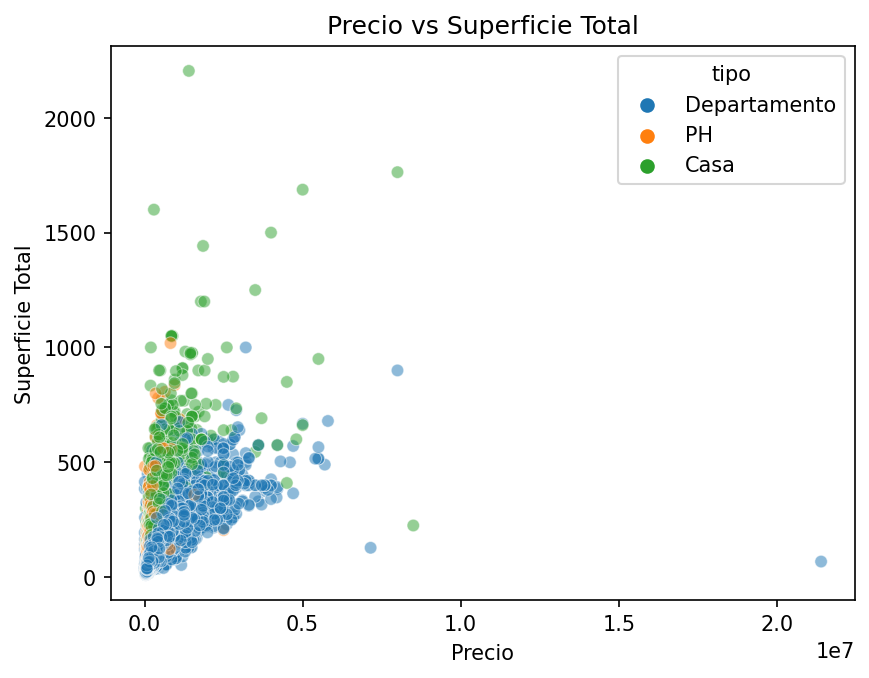

In [135]:
plt.figure(dpi=150)
grf = sns.scatterplot(data=df, x="precio", y="superficie_total", alpha=0.5, hue="tipo")
grf = grf.set(
    title="Precio vs Superficie Total",
    xlabel="Precio",
    ylabel="Superficie Total",
)

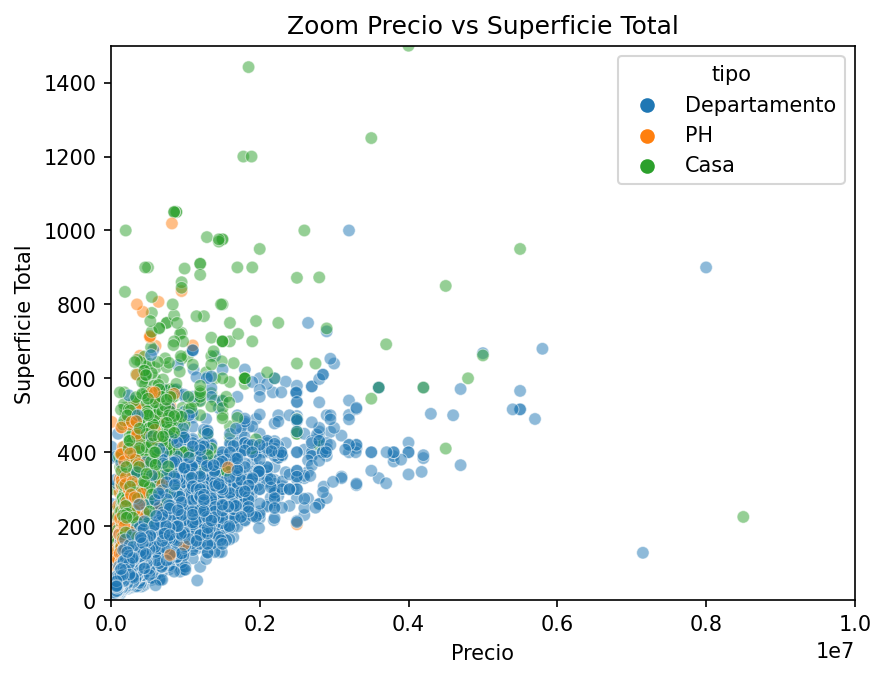

In [136]:
plt.figure(dpi=150)
grf = sns.scatterplot(data=df, x="precio", y="superficie_total", alpha=0.5, hue="tipo")
grf = grf.set(
    title="Zoom Precio vs Superficie Total",
    xlim=(0, 10000000),
    ylim=(0, 1500),
    xlabel="Precio",
    ylabel="Superficie Total",
)

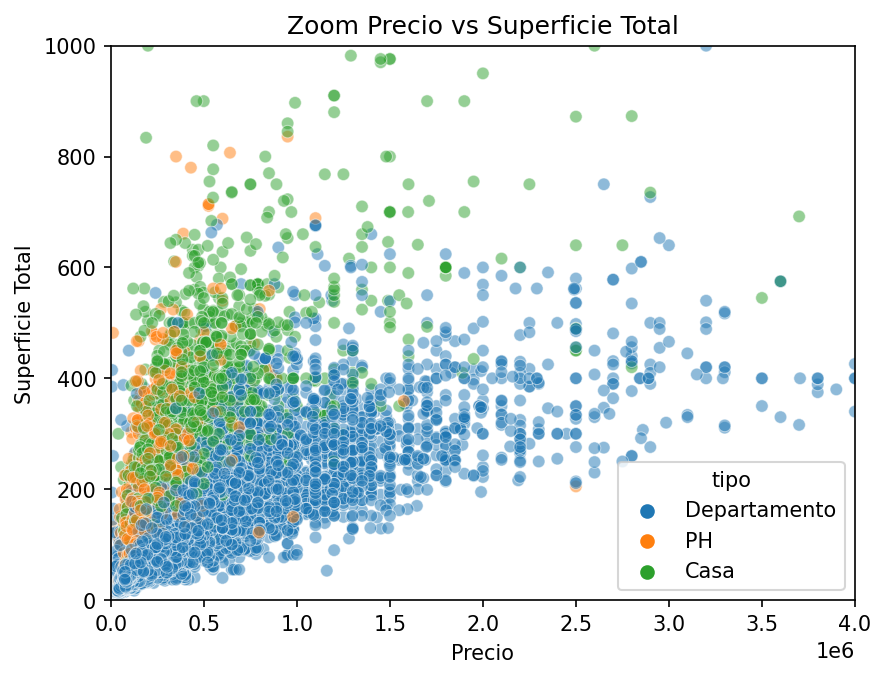

In [137]:
plt.figure(dpi=150)
grf = sns.scatterplot(data=df, x="precio", y="superficie_total", alpha=0.5, hue="tipo")
grf = grf.set(
    title="Zoom Precio vs Superficie Total",
    xlim=(0, 4000000),
    ylim=(0, 1000),
    xlabel="Precio",
    ylabel="Superficie Total",
)

<h4 align="center"><b> Dividimos el dataSet </b></h4>

#### Veamos que porcentaje del dataset eliminamos a lo largo del pre-procesamiento:

In [138]:
tam_final=df.shape[0]
print(f"Se eliminaron: {tam_inicial-tam_final} filas a lo largo de la totalidad del pre-procesamiento, lo cual representa un {round((tam_inicial-tam_final) / tam_inicial * 100, 3)}%")

Se eliminaron: 8121 filas a lo largo de la totalidad del pre-procesamiento, lo cual representa un 10.048%


In [139]:
df.reset_index(drop=True, inplace=True)

In [140]:
target = df['precio'] / df['superficie_total']

In [141]:
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=0)

In [142]:
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

<h4 align="center"><b> Determinar, de ser posible, estrategias para reparar los valores faltantes </b></h4>

#### Completamos las latitudes y longitudes con respecto a la media de su barrio.

In [143]:
valores_place = x_train.barrio.unique()

In [144]:
medias_latitud = {}
medias_latitud['default'] = x_train.latitud.mean()
medias_longitud = {}
medias_longitud['default'] = x_train.longitud.mean()
valores_place = x_train.groupby(by=["barrio"]).mean().index
grupos = x_train.groupby(by=["barrio"]).mean()

In [145]:
for place in valores_place:
    medias_latitud[place] = grupos.latitud[place]
    medias_longitud[place] = grupos.longitud[place]

In [146]:
for place in valores_place:
    mask = (x_train["longitud"].isnull()) & (x_train["barrio"] == place)
    x_train.loc[mask, "longitud"] = medias_longitud.get(place, medias_longitud['default'])

In [147]:
for place in valores_place:
    mask = (x_train["latitud"].isnull()) & (x_train["barrio"] == place)
    x_train.loc[mask, "latitud"] = medias_latitud.get(place, medias_latitud['default'])

#### Completamos los datos faltantes de Dormitorios utilizando la moda segun la cantidad de ambientes, es decir, Imputacion Hot Deck

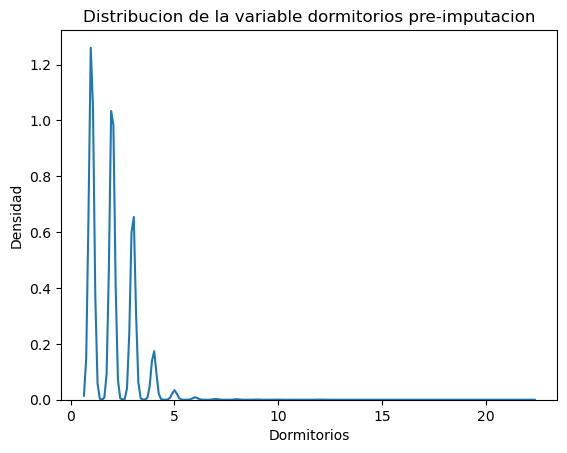

In [148]:
# Distribucion de la variable dormitorios antes de imputar o reparar datos
sns_hist = sns.kdeplot(data=x_train.dormitorios).set(
    title="Distribucion de la variable dormitorios pre-imputacion",
    xlabel="Dormitorios",
    ylabel="Densidad",
)

Vamos a calcular la moda para el feature dormitorios dependiendo de cuantos ambientes tenga la propiedad

In [149]:
moda_dormitorios = {}
#Necesito una moda por default por si la moda es nan en un ambiente dado
moda_dormitorios['default'] = x_train['ambientes'].mode()[0]
valores_ambientes = x_train.ambientes.unique().tolist()

In [150]:
# Calculamos la moda para cada valor unico de ambientes
for n in valores_ambientes:
    aux = x_train[(x_train.ambientes == n) & (x_train.dormitorios.notnull())]
    #Si la moda es nan no lo guardo en el diccionario
    if(aux.shape[0] == 0): continue
    moda_dormitorios[n] = aux.dormitorios.mode()[0]

In [151]:
# Completamos los nan de dormitorios con su respectiva moda segun la cantidad de ambientes
x_train_na = x_train[x_train.dormitorios.isna()]
unique_rooms = x_train_na.ambientes.unique().tolist()

# Le asignamos el valor que corresponda a cada celda de dormitorio que este vacia
for n in unique_rooms:
    mask = ((x_train["dormitorios"].isnull())) & (x_train["ambientes"] == n)
    x_train.loc[mask, "dormitorios"] = moda_dormitorios.get(n, moda_dormitorios['default'])

In [152]:
# Volvemos a chequear que no tengamos datos faltantes luego de imputar
x_train.dormitorios.isnull().sum()

0

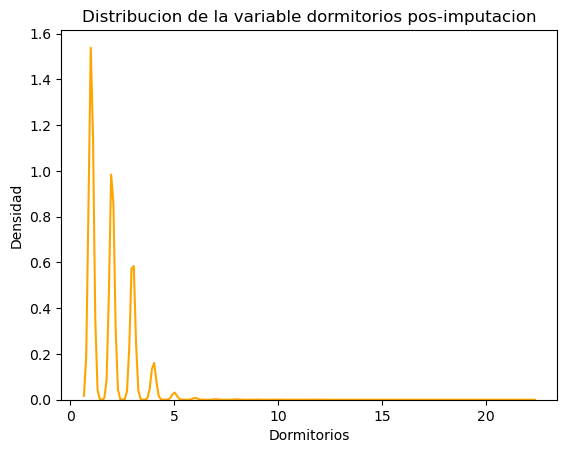

In [153]:
# Distribucion de la variable dormitorios despues de imputar o reparar datos
sns_hist = sns.kdeplot(data=x_train.dormitorios, color='orange').set(
    title="Distribucion de la variable dormitorios pos-imputacion",
    xlabel="Dormitorios",
    ylabel="Densidad",
)

Se observa que aumento la frecuencia del valor 1.

#### Agreguemos una feature nueva, la comuna a la que corresponde cada propiedad

In [154]:
import geopandas as geopd
import rtree
from geopandas.tools import sjoin

In [155]:
# Vamos a utilizar un csv con los datos que necesitamos, se obtuvo de la pagina del gobierno de la ciudad
#url='https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/comunas/comunas.csv'
#dp_comunas = geopd.read_file(url)
dp_comunas = geopd.read_file("./comunas.csv")
df_comunas = dp_comunas.copy()

In [156]:
# Tomamos solamente las columnas que necesitamos
df_comunas=df_comunas.filter(['COMUNAS','geometry'])
df_comunas.rename(columns={'COMUNAS':'comuna'},inplace=True)
# Casteamos las comunas a enteros para mayor comodidad
df_comunas['comuna']=df_comunas.comuna.astype(float)
df_comunas['comuna']=df_comunas.comuna.astype(int)

In [157]:
# Asignamos sus geometrias a las filas cuyas coordenadas estaban en NaN y ahora hemos imputado
new_geometry=geopd.points_from_xy(x_train[x_train.geometry.is_empty].longitud, x_train[x_train.geometry.is_empty].latitud)
x_train.loc[x_train.geometry.is_empty,'geometry'] = new_geometry

In [158]:
# Unimos los dataframes asignando la comuna que le corresponde a cada punto segun su coordenada
tam_inicial=x_train.shape[0]
df_comunas.set_crs('EPSG:4326', inplace=True)
x_train = x_train.sjoin(df_comunas, how="left")

In [159]:
# Borramos las filas que no caian dentro de los limites de la ciudad, pero sin borrar las que tenian sus coordenadas en NaN
x_train=x_train[~((x_train.index_right.isna()) & ~(x_train.geometry.is_empty))]
x_train.drop(columns='index_right', inplace=True)

Al hacer la asignacion de comunas segun coordenada, todas las propiedades que no se encuentren dentro de los limites son descartadas. Verifiquemos que el chequeo previo haya funcionado, no deberiamos perder ninguna fila.

In [160]:
tam_final=x_train.shape[0]
print(f"Se eliminaron: {tam_inicial-tam_final} filas al asignar comunas")

Se eliminaron: 0 filas al asignar comunas


[Text(0.5, 80.7222222222222, 'Longitud'),
 Text(88.88164283049609, 0.5, 'Latitud')]

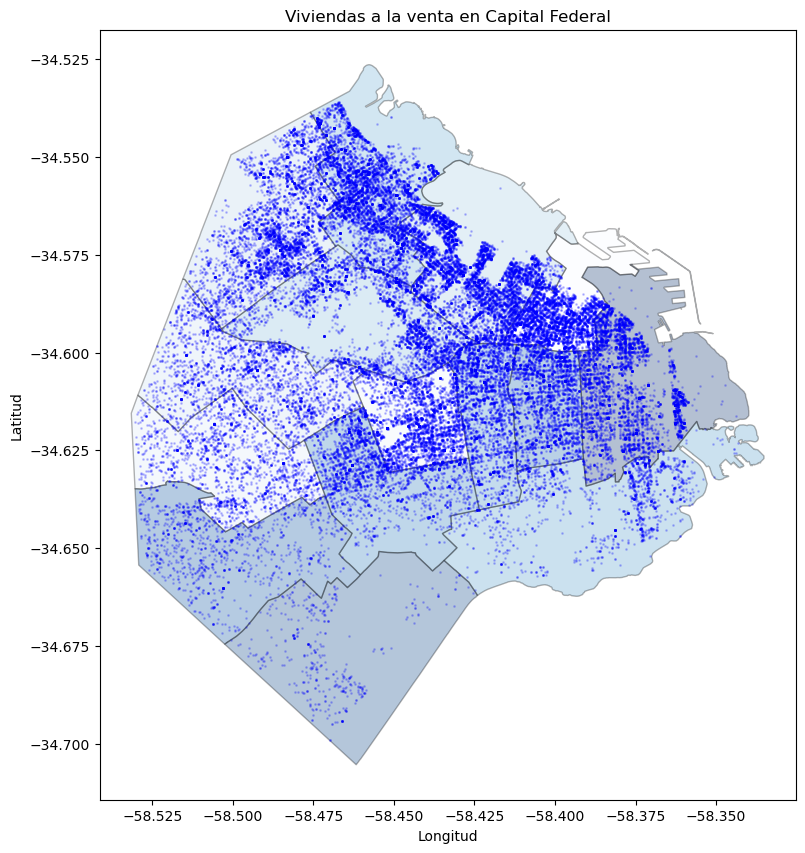

In [161]:
# Graficamos las viviendas en un mapa para visualizar su distribucion espacial
fig, ax = plt.subplots(figsize=(10,10))
df_comunas.plot(ax=ax,alpha=0.3, facecolor='Grey',edgecolor='k', linewidth=1, cmap='Blues').set(title='Viviendas a la venta en Capital Federal')
x_train.plot(ax=ax, alpha=0.2, color='blue', markersize=1).set(xlabel='Longitud', ylabel="Latitud")


In [162]:
#Ya no necesitare el feature geometry
x_train.drop(columns=["geometry"],inplace=True,)

In [163]:
x_train = x_train.sort_index()

## Terminamos con el preprocesamiento

In [164]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58161 entries, 0 to 58160
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   latitud              58161 non-null  float64
 1   longitud             58161 non-null  float64
 2   barrio               58161 non-null  object 
 3   tipo                 58161 non-null  object 
 4   ambientes            58161 non-null  float64
 5   dormitorios          58161 non-null  float64
 6   superficie_total     58161 non-null  float64
 7   superficie_cubierta  58161 non-null  float64
 8   precio               58161 non-null  float64
 9   dia                  58161 non-null  int64  
 10  mes                  58161 non-null  int64  
 11  comuna               58161 non-null  int64  
dtypes: float64(7), int64(3), object(2)
memory usage: 5.8+ MB


Para reducir la dimensionalidad no necesitamos features de formato string

Justificacion del drop:
   * Barrio: Sera reemplazado por comuna
   * Dia: Irrelevante
   * Mes: Irrelevante
   * Precio: Porque tiene relacion con la target
   * Superficie_total: Porque tiene relacion con la target

In [165]:
feature_eliminar = ['barrio', 'dia', 'mes', 'precio', 'superficie_total']

In [166]:
x_train.drop(columns=feature_eliminar,inplace=True)

## OneHot

Seguidamente ejecutamos oneHot al feature tipo <br>
*Por que no ordinal?* Porque no se encuentra un orden relativo ni absoluto para decir porque PH debe ser 3 y Casa 1(ejm)

In [167]:
ohe = OneHotEncoder(drop='first')
f_array = ohe.fit_transform(x_train[['tipo']]).toarray()
f_name_tipo = np.array(ohe.categories_).ravel()[1:]#Porque elimine el 1ero
feature_tipo = pd.DataFrame(f_array, columns=f_name_tipo)

In [168]:
x_train = pd.concat([x_train, feature_tipo], axis=1)

In [169]:
x_train.drop(columns=["tipo"],inplace=True)

### Reflejamos lo mismo en el tests

In [170]:
x_test = preprocesamiento(x_test, feature_eliminar, medias_latitud, medias_longitud, moda_dormitorios, ohe, df_comunas)

### Guardamos para continuar en la siguiente notebook

In [171]:
x_train.to_csv('./DataSet/x_train')

In [172]:
y_train.to_csv('./DataSet/y_train')

In [173]:
x_test.to_csv('./DataSet/x_test')

In [174]:
y_test.to_csv('./DataSet/y_test')

In [ ]:
df_completo = preprocesamiento(df, ['dia','mes','barrio'], medias_latitud, medias_longitud, moda_dormitorios, ohe, df_comunas)
df_completo.to_csv('./DataSet/df_completo')

In [ ]:
df_completo

,latitud,longitud,ambientes,dormitorios,superficie_total,superficie_cubierta,precio,Departamento,PH,comuna
0,-34.637319,-58.361124,3.0,2.0,58.0,55.0,82900.0,1.0,0.0,4
1,-34.628647,-58.361871,4.0,3.0,70.0,70.0,99000.0,1.0,0.0,4
2,-34.623886,-58.412746,2.0,1.0,61.0,46.0,100000.0,0.0,1.0,5
3,-34.625588,-58.423056,4.0,2.0,104.0,54.0,185000.0,0.0,1.0,5
4,-34.629398,-58.425852,2.0,1.0,62.0,44.0,100000.0,1.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...
72697,-34.603245,-58.489810,4.0,3.0,130.0,100.0,220000.0,1.0,0.0,11
72698,-34.614063,-58.482814,3.0,2.0,68.0,60.0,161000.0,1.0,0.0,11
72699,-34.614175,-58.479062,1.0,1.0,51.0,30.0,75500.0,1.0,0.0,11
72700,-34.614175,-58.479062,1.0,1.0,37.0,31.0,74500.0,1.0,0.0,11


### **4. Regresión**

En esta etapa se busca predecir el precio de la propiedad utilizando dos modelos diferentes.
Para todos los modelos se pide:

* Realizar las tareas de ingeniería de características necesarias para trabajar con
cada algoritmo (encoding, normalización, etc)
* Todos los modelos deben ser entrenados también con el dataset generado en el
punto **1 d)**

**Modelo 1: KNN**

a. Construir un modelo [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) para regresión y optimizar sus hiperparámetros
mediante *k-fold Cross Validation* para obtener la mejor performance .¿Cuántos
*folds* utilizaron? ¿Qué métrica consideran adecuada para buscar los parámetros?

b. Evaluar la performance del modelo en el conjunto de evaluación, explicar todas
las métricas. Comparar con la performance de entrenamiento.

In [ ]:
# Codigo

In [ ]:
# Codigo

In [ ]:
# Codigo

**Modelo 2: XGBoost**

a. Construir un modelo **XGBoost** y optimizar sus hiperparámetros mediante *k-fold
Cross Validation* para obtener la mejor performance. ¿Cuántos *folds* utilizaron?
¿Qué métrica consideran adecuada para buscar los parámetros?

b. Evaluar la performance del modelo en el conjunto de evaluación, explicar todas
las métricas. Comparar con la performance de entrenamiento.

In [ ]:
# Codigo

In [ ]:
# Codigo

In [ ]:
# Codigo

**Modelo 3: a elección**

a. En este punto se debe entrenar (mediante *cross-validation*) un modelo elegido
por el grupo. Se debe evaluar su performance en entrenamiento y sobre el
conjunto de evaluación explicando todas las métricas.

In [ ]:
# Codigo

In [ ]:
# Codigo

In [ ]:
# Codigo

¿Qué modelo elegirían para predecir el precio de venta de las propiedades?

R:

### **5. Conclusiones**

Realizar las conclusiones correspondientes al trabajo realizado en su totalidad, destacando
principalmente los aspectos que consideren más relevantes. Comentar brevemente qué otras
opciones hubiesen explorado y quedaron fuera del alcance de este trabajo

R: